In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, mean_squared_error
from sklearn import metrics
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
from keras.optimizers import Adam



/Users/floris/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [253]:
# Check pandas version
try:
    import pandas as pd
    print(f"pandas=={pd.__version__}")
except ImportError:
    print("pandas not found.")

# Check numpy version
try:
    import numpy as np
    print(f"numpy=={np.__version__}")
except ImportError:
    print("numpy not found.")

# Check matplotlib version
try:
    import matplotlib
    print(f"matplotlib=={matplotlib.__version__}")
except ImportError:
    print("matplotlib not found.")

# Check seaborn version
try:
    import seaborn as sns
    print(f"seaborn=={sns.__version__}")
except ImportError:
    print("seaborn not found.")

# Check scikit-learn version
try:
    import sklearn
    print(f"scikit-learn=={sklearn.__version__}")
except ImportError:
    print("scikit-learn not found.")

# Check tensorflow version
try:
    import tensorflow as tf
    print(f"tensorflow=={tf.__version__}")
except ImportError:
    print("tensorflow not found.")

# Check keras version
try:
    import keras
    print(f"keras=={keras.__version__}")
except ImportError:
    print("keras not found.")

# Check collections version (not a third-party package)
try:
    from collections import Counter
    print("collections is part of Python's standard library.")
except ImportError:
    print("collections not found.")

# Check keras.optimizers version (from TensorFlow)
try:
    from keras.optimizers import Adam
    print("keras.optimizers is part of the keras module.")
except ImportError:
    print("keras.optimizers not found.")


pandas==2.2.3
numpy==2.0.2
matplotlib==3.9.2
seaborn==0.13.2
scikit-learn==1.5.2
tensorflow==2.18.0
keras==3.6.0
collections is part of Python's standard library.
keras.optimizers is part of the keras module.


In [2]:
# Load dataset
df = pd.read_csv('/Users/floris/Documents/Master/Thesis/Data/RT_IOT2022.csv')

# Adjust Pandas settings
pd.set_option('display.max_columns', None)

In [3]:
# Print dataset information
print("Dataset Info:")
print(df.info())

# Display basic statistics
print("\nBasic Statistics:")
print(df.describe(include='all'))

# Display the first few rows of the dataset
print("\nSample Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display column names
print("\nColumn Names:")
print(df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209959 entries, 0 to 209958
Data columns (total 84 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id.orig_p                 209959 non-null  int64  
 1   id.resp_p                 209959 non-null  int64  
 2   proto                     209959 non-null  object 
 3   service                   209959 non-null  object 
 4   flow_duration             209959 non-null  float64
 5   fwd_pkts_tot              209959 non-null  int64  
 6   bwd_pkts_tot              209959 non-null  int64  
 7   fwd_data_pkts_tot         209959 non-null  int64  
 8   bwd_data_pkts_tot         209959 non-null  int64  
 9   fwd_pkts_per_sec          209959 non-null  float64
 10  bwd_pkts_per_sec          209959 non-null  float64
 11  flow_pkts_per_sec         209959 non-null  float64
 12  down_up_ratio             209959 non-null  float64
 13  fwd_header_size_tot       2099


Attack Type Distribution:
 Attack_type
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64


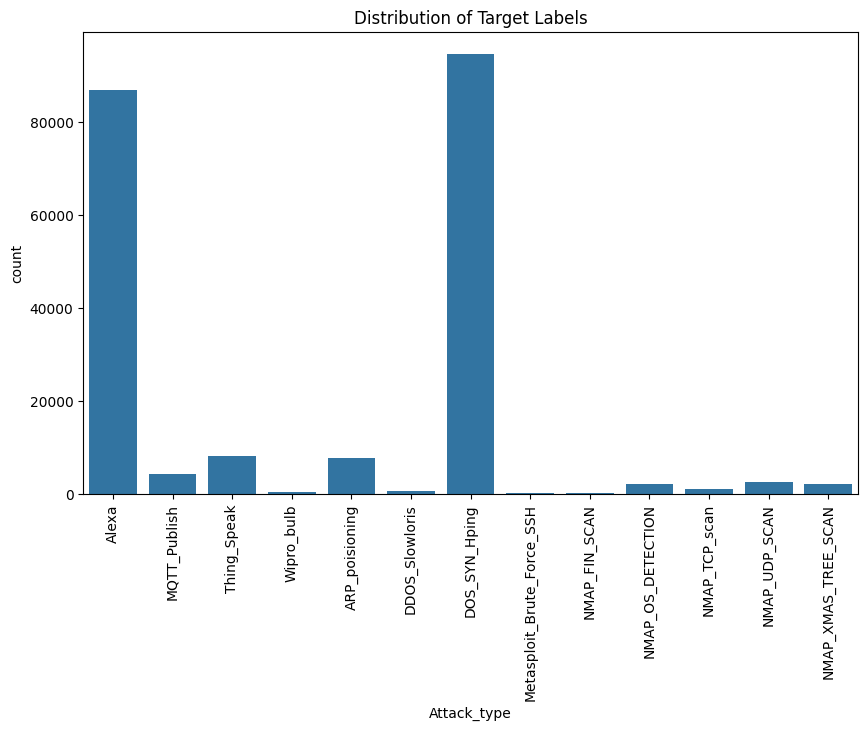

In [4]:
# 3. Class Distribution for 'Attack_type'
print("\nAttack Type Distribution:\n", df['Attack_type'].value_counts())

# Plot the distribution of Attack Types
plt.figure(figsize=(10,6))
sns.countplot(x='Attack_type', data=df)
plt.title('Distribution of Target Labels')
plt.xticks(rotation=90)
plt.savefig("Class_distribution.png", bbox_inches='tight')
plt.show()

# EDA

### Preprossesing for feature selection methods

In [5]:
# Creating the binary target column and dropping the Attack_Type column

attack_labels = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION',
    'NMAP_TCP_scan', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Create the 'Attack' column with 1 for attacks and 0 for normal
df['Attack'] = df['Attack_type'].apply(lambda x: 1 if x in attack_labels else 0)
df = df.drop('Attack_type', axis=1)

print("\nAttack Type Distribution:\n", df['Attack'].value_counts())


Attack Type Distribution:
 Attack
1    110610
0     99349
Name: count, dtype: int64


### Correlation Analysis

In [6]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Dictionary to store the mappings for each column
label_mappings = {}

# Apply label encoding and save mappings
for column in ['proto', 'service']:
    df[column] = label_encoder.fit_transform(df[column])
    # Store the mapping of labels to integers
    label_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mappings for each column
print("Label mappings:")
for column, mapping in label_mappings.items():
    print(f"{column}: {mapping}")

# Split target column from the rest of the data
X = df.drop(columns=['Attack']) # This is the target column
y = df['Attack']

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Label mappings:
proto: {'icmp': np.int64(0), 'tcp': np.int64(1), 'udp': np.int64(2)}
service: {'-': np.int64(0), 'dhcp': np.int64(1), 'dns': np.int64(2), 'http': np.int64(3), 'irc': np.int64(4), 'mqtt': np.int64(5), 'ntp': np.int64(6), 'radius': np.int64(7), 'ssh': np.int64(8), 'ssl': np.int64(9)}


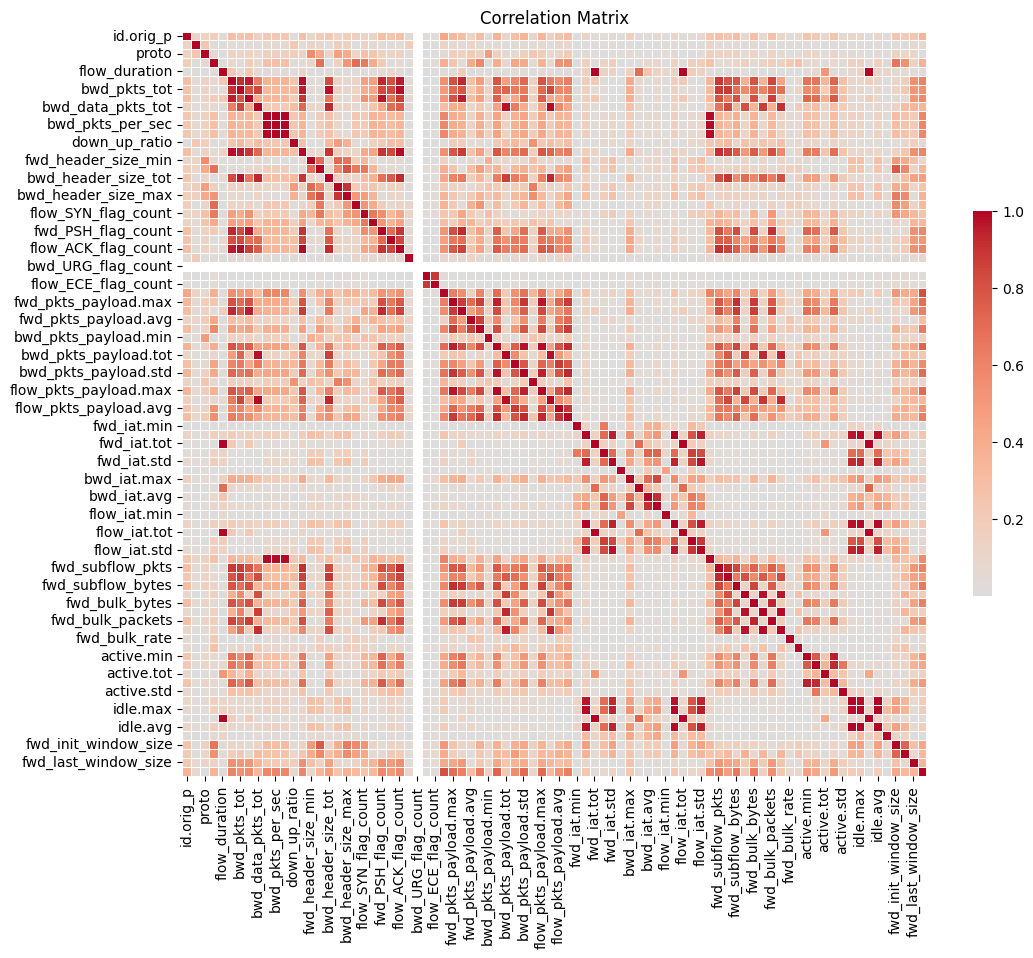

In [7]:
# Calculate the absolute correlation matrix
correlation_matrix = df.corr().abs()

# Define the mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creating heatmap for the full correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

In [8]:
# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find pairs of features with correlation greater than 0.9
high_correlation_pairs = [(column, row) for column in upper.columns for row in upper.index if upper.loc[row, column] > 0.9]
print(high_correlation_pairs)

[('bwd_pkts_tot', 'fwd_pkts_tot'), ('fwd_data_pkts_tot', 'fwd_pkts_tot'), ('bwd_pkts_per_sec', 'fwd_pkts_per_sec'), ('flow_pkts_per_sec', 'fwd_pkts_per_sec'), ('flow_pkts_per_sec', 'bwd_pkts_per_sec'), ('fwd_header_size_tot', 'fwd_pkts_tot'), ('fwd_header_size_tot', 'bwd_pkts_tot'), ('bwd_header_size_tot', 'bwd_pkts_tot'), ('bwd_header_size_tot', 'bwd_data_pkts_tot'), ('bwd_header_size_tot', 'fwd_header_size_tot'), ('bwd_header_size_max', 'bwd_header_size_min'), ('fwd_PSH_flag_count', 'fwd_pkts_tot'), ('fwd_PSH_flag_count', 'fwd_data_pkts_tot'), ('flow_ACK_flag_count', 'fwd_pkts_tot'), ('flow_ACK_flag_count', 'bwd_pkts_tot'), ('flow_ACK_flag_count', 'fwd_header_size_tot'), ('flow_ACK_flag_count', 'bwd_header_size_tot'), ('fwd_pkts_payload.tot', 'fwd_pkts_tot'), ('fwd_pkts_payload.tot', 'fwd_data_pkts_tot'), ('fwd_pkts_payload.tot', 'fwd_PSH_flag_count'), ('bwd_pkts_payload.max', 'fwd_pkts_payload.max'), ('bwd_pkts_payload.tot', 'bwd_data_pkts_tot'), ('bwd_pkts_payload.std', 'bwd_pkts_p

In [9]:
# Combine highly correlated features
combined_features = []
for feature1, feature2 in high_correlation_pairs:
    # Check if both features still exist in the dataframe
    if feature1 in df.columns and feature2 in df.columns:
        # Combine the two features by taking the mean (you can change to sum or another operation if needed)
        combined_feature_name = f"{feature1}_{feature2}_combined"
        df[combined_feature_name] = df[[feature1, feature2]].mean(axis=1)
        # Drop the original features
        df = df.drop(columns=[feature1, feature2])
        combined_features.append(combined_feature_name)

# Print the combined features
print(f"Combined features created: {combined_features}")

Combined features created: ['bwd_pkts_tot_fwd_pkts_tot_combined', 'bwd_pkts_per_sec_fwd_pkts_per_sec_combined', 'bwd_header_size_tot_bwd_data_pkts_tot_combined', 'bwd_header_size_max_bwd_header_size_min_combined', 'fwd_PSH_flag_count_fwd_data_pkts_tot_combined', 'flow_ACK_flag_count_fwd_header_size_tot_combined', 'bwd_pkts_payload.max_fwd_pkts_payload.max_combined', 'flow_pkts_payload.max_bwd_pkts_payload.std_combined', 'flow_pkts_payload.tot_bwd_pkts_payload.tot_combined', 'flow_pkts_payload.std_flow_pkts_payload.avg_combined', 'fwd_iat.tot_flow_duration_combined', 'fwd_iat.std_fwd_iat.max_combined', 'bwd_iat.std_bwd_iat.avg_combined', 'flow_iat.std_flow_iat.max_combined', 'payload_bytes_per_second_flow_pkts_per_sec_combined', 'bwd_subflow_pkts_fwd_subflow_pkts_combined', 'bwd_bulk_bytes_bwd_subflow_bytes_combined', 'fwd_bulk_packets_fwd_bulk_bytes_combined', 'active.avg_active.min_combined', 'idle.max_idle.min_combined', 'idle.tot_flow_iat.tot_combined']


In [10]:
print(df.shape)

(209959, 63)


## Preprocess data for feature selection

## Label encode the Proto and Service column

### Train - Validation - Test data split

In [11]:
X = df.drop('Attack', axis=1)  # All columns except the target
y = df['Attack']               # The target column only

# Split into Train Validation and Test sets

# First split: 85% train+validation, 15% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

# Second split: 70% train, 15% validation from the train+validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, shuffle=True) # 0.1765 is approximately 15% of the 85% that was originally taken for train+validation 

# RF feature selection method graphs

### Pearson Correlation Coefficient (PCC)

In [12]:
# Pearson Correlation Coefficient (PCC)
correlation_matrix = pd.DataFrame(df, columns=df.columns.drop(['Attack'])).corrwith(pd.Series(y_train))
top_30_pcc_features = correlation_matrix.abs().sort_values(ascending=False).head(30).index

/Users/floris/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/floris/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
# Ensure X_train and X_val are DataFrames with the same columns as the original DataFrame
X_train = pd.DataFrame(X_train, columns=df.columns)
X_val = pd.DataFrame(X_val, columns=df.columns)

# Initialize lists to store results
PCC_metrics = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Iterate from 5 to 20 features
for num_features in range(5, 31):
    # Select the top features based on the current number
    selected_features = top_30_pcc_features[:num_features]
    X_train_subset = X_train[selected_features]
    X_val_subset = X_val[selected_features]
    
    # Train Random Forest model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_subset, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_val_subset)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Append results to metrics dictionary
    PCC_metrics['num_features'].append(num_features)
    PCC_metrics['accuracy'].append(accuracy)
    PCC_metrics['recall'].append(recall)
    PCC_metrics['precision'].append(precision)
    PCC_metrics['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_df = pd.DataFrame(PCC_metrics)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['num_features'], metrics_df['accuracy'], label='Accuracy')
plt.plot(metrics_df['num_features'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['num_features'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['num_features'], metrics_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Random Forest Performance by Number of PCC Features')
plt.legend()
plt.grid(True)
plt.savefig('PCC_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


In [ ]:
# Make the PCC train-, validation- and testsets with chosen number of features
RF_pcc_features = top_30_pcc_features[:20] # the top 20 number of features is chosen based on the outcome

# Create train, validation, and test sets with only the selected features
RF_X_train_pcc = X_train[RF_pcc_features]
RF_X_val_pcc = X_val[RF_pcc_features]
RF_X_test_pcc = X_test[RF_pcc_features]

### Recursive Feature Elimination (RFE) 

In [14]:
#  Step 1: Run RFE once to rank the top 30 features
rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=30)  # Selecting top 30 features initially
rfe.fit(X_train, y_train)

# Extract the ranking of features and keep the top 30
top_30_rfe_features = [f for f, r in zip(df.columns.drop(['Attack']), rfe.support_) if r]

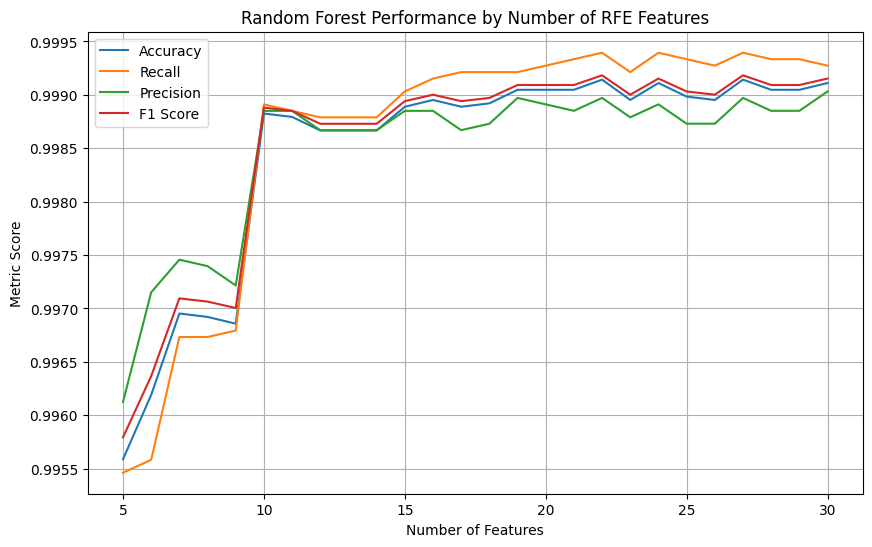

In [ ]:
# Initialize lists to store results
metrics_rfe = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Step 2: Train the model using subsets of the top 20 features, from 5 up to 20
for num_features in range(5, 31):
    # Select the top `num_features` from the already-ranked features
    selected_features = top_30_rfe_features[:num_features]
    
    # Use the DataFrame to select the correct columns, then convert to NumPy arrays
    X_train_subset = pd.DataFrame(X_train, columns=df.columns.drop(['Attack']))[selected_features].values
    X_val_subset = pd.DataFrame(X_val, columns=df.columns.drop(['Attack']))[selected_features].values
    
    # Train a Random Forest model on the selected features
    rf.fit(X_train_subset, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_val_subset)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Append results to metrics dictionary
    metrics_rfe['num_features'].append(num_features)
    metrics_rfe['accuracy'].append(accuracy)
    metrics_rfe['recall'].append(recall)
    metrics_rfe['precision'].append(precision)
    metrics_rfe['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_rfe_df = pd.DataFrame(metrics_rfe)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_rfe_df['num_features'], metrics_rfe_df['accuracy'], label='Accuracy')
plt.plot(metrics_rfe_df['num_features'], metrics_rfe_df['recall'], label='Recall')
plt.plot(metrics_rfe_df['num_features'], metrics_rfe_df['precision'], label='Precision')
plt.plot(metrics_rfe_df['num_features'], metrics_rfe_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Random Forest Performance by Number of RFE Features')
plt.legend()
plt.grid(True)
plt.savefig('RFE_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


In [15]:
# Make the PCC train-, validation- and testsets with chosen number of features
RF_rfe_features = top_30_rfe_features[:15] # the top 15 number of features is chosen based on the outcome
# Create train, validation, and test sets with only the selected features
RF_X_train_RFE = X_train[RF_rfe_features]
RF_X_val_RFE = X_val[RF_rfe_features]
RF_X_test_RFE = X_test[RF_rfe_features]

### Mutual Information (MI)

In [16]:
# Mutual Information (MI)
mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=df.columns.drop(['Attack'])).sort_values(ascending=False)
top_30_mi_features = mi_series.head(30).index

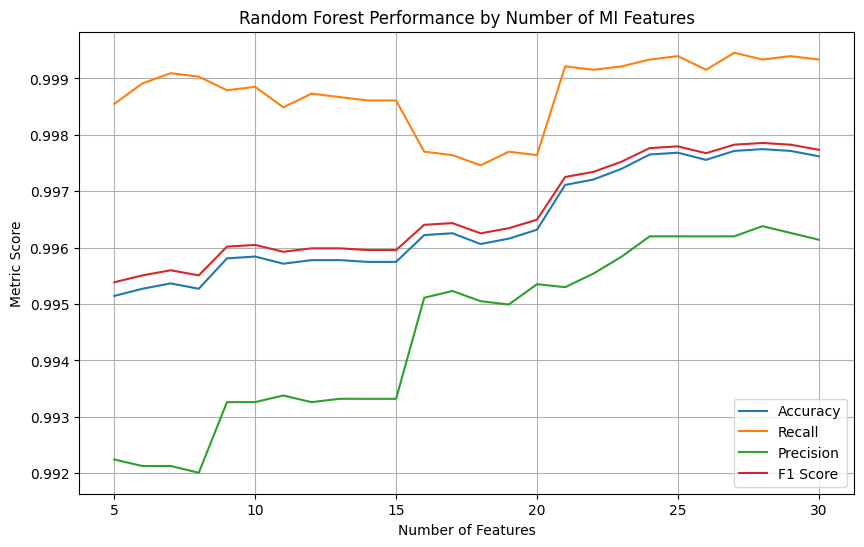

In [ ]:
# Initialize lists to store results
metrics_mi = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Iterate from 5 to 20 features
for num_features in range(5, 31):
    # Select the top features based on the current number
    selected_features = top_30_mi_features[:num_features]
    
    # Use the DataFrame to select the correct columns, then convert to NumPy arrays
    X_train_subset = pd.DataFrame(X_train, columns=df.columns.drop(['Attack']))[selected_features].values
    X_val_subset = pd.DataFrame(X_val, columns=df.columns.drop(['Attack']))[selected_features].values
    
    # Train Random Forest model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_subset, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_val_subset)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Append results to metrics dictionary
    metrics_mi['num_features'].append(num_features)
    metrics_mi['accuracy'].append(accuracy)
    metrics_mi['recall'].append(recall)
    metrics_mi['precision'].append(precision)
    metrics_mi['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_mi_df = pd.DataFrame(metrics_mi)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_mi_df['num_features'], metrics_mi_df['accuracy'], label='Accuracy')
plt.plot(metrics_mi_df['num_features'], metrics_mi_df['recall'], label='Recall')
plt.plot(metrics_mi_df['num_features'], metrics_mi_df['precision'], label='Precision')
plt.plot(metrics_mi_df['num_features'], metrics_mi_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Random Forest Performance by Number of MI Features')
plt.legend()
plt.grid(True)
plt.savefig('MI_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


In [17]:
# Make the MI train-, validation- and testsets with chosen number of features
RF_mi_features = top_30_mi_features[:21] # the top 21 number of features is chosen based on the outcome
# Create train, validation, and test sets with only the selected features
RF_X_train_MI = X_train[RF_mi_features]
RF_X_val_MI = X_val[RF_mi_features]
RF_X_test_MI = X_test[RF_mi_features]

# Auto encoder feature selection graphs

## Autoencoder Nmbr of features PCC

621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 451us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 440us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 431us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1016s 992us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 450us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 443us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 438us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s

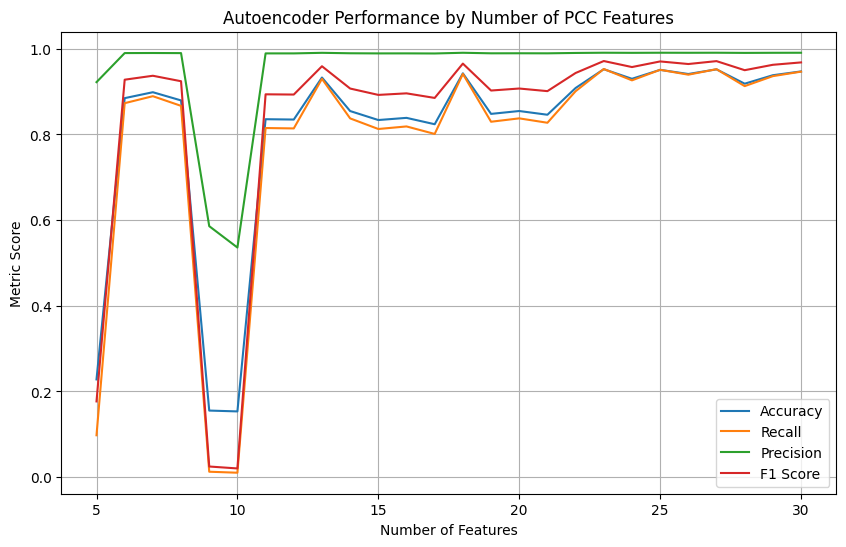

In [17]:
# Initialize lists to store results for the autoencoder
metrics_autoencoder = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Iterate from 5 to 20 features
for num_features in range(5, 31):
    # Select the top features based on the current number
    selected_features = top_30_pcc_features[:num_features]
    
    # Re-select the features from the original DataFrame each time in the loop
    features = df[selected_features]
    labels = df['Attack']
    
    # Normalize the features to range [0, 1]
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Split the data into normal (Attack == 0) and attack (Attack == 1)
    normal_data = features_normalized[labels == 0]
    attack_data = features_normalized[labels == 1]

    # Split the normal data into training and validation sets
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

    # Use the attack data and remaining normal data as the test set
    X_test = np.vstack([X_val, attack_data])  # Test set includes both normal and attack data
    y_test = np.hstack([np.zeros(len(X_val)), np.ones(len(attack_data))])  # 0 for normal, 1 for attack

    # Define the autoencoder architecture for the subset of features
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    # Build the autoencoder layers (encoder and decoder as previously defined)
    encoder = Dense(256)(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(128)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(64)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(32)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(16)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    decoder = Dense(32)(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(64)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(128)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(256)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    output_layer = Dense(input_dim, activation='sigmoid')(decoder)
    
    # Compile the autoencoder
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    # Train the autoencoder with a reduced number of epochs for testing
    initial_epochs = 30
    autoencoder.fit(X_train, X_train,
                    epochs=initial_epochs,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0)

    # Set the threshold based on reconstruction error in the validation set
    reconstructions_val = autoencoder.predict(X_val)
    reconstruction_errors_val = np.mean(np.power(X_val - reconstructions_val, 2), axis=1)
    threshold = np.percentile(reconstruction_errors_val, 95)  # 95th percentile

    # Evaluate performance on the test set
    reconstructions_test = autoencoder.predict(X_test)
    reconstruction_errors_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

    # Classify as anomaly if error > threshold
    y_pred_test = (reconstruction_errors_test > threshold).astype(int)

    # Calculate metrics for this number of features
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, zero_division=1)
    precision = precision_score(y_test, y_pred_test, zero_division=1)
    f1 = f1_score(y_test, y_pred_test, zero_division=1)
    
    # Append results to metrics dictionary
    metrics_autoencoder['num_features'].append(num_features)
    metrics_autoencoder['accuracy'].append(accuracy)
    metrics_autoencoder['recall'].append(recall)
    metrics_autoencoder['precision'].append(precision)
    metrics_autoencoder['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_autoencoder_df = pd.DataFrame(metrics_autoencoder)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['accuracy'], label='Accuracy')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['recall'], label='Recall')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['precision'], label='Precision')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Autoencoder Performance by Number of PCC Features')
plt.legend()
plt.grid(True)
plt.savefig('Autoencoder_PCC_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


## Autoencoder Nmbr of feature RFE

621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 450us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 449us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 485us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 3s 839us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 

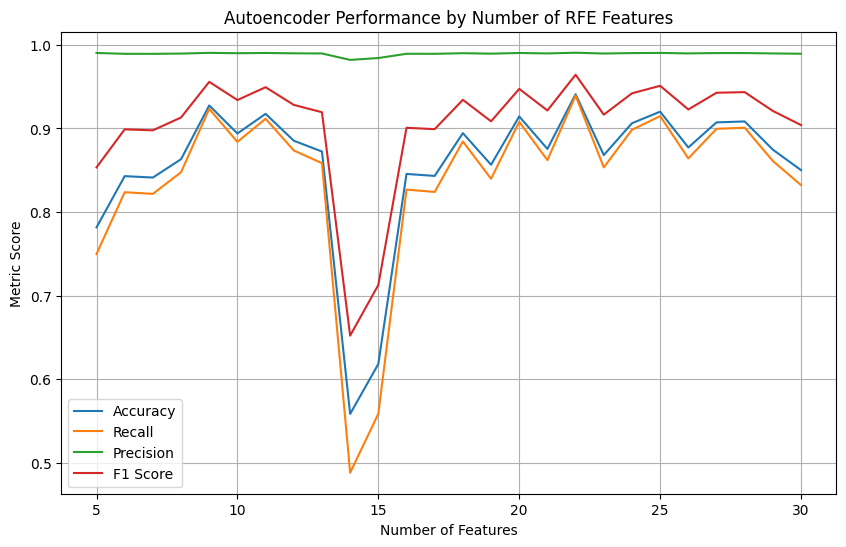

In [18]:
# Initialize lists to store results for the autoencoder
metrics_autoencoder = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Iterate from 5 to 20 features
for num_features in range(5, 31):
    # Select the top features based on the current number
    selected_features = top_30_rfe_features[:num_features]
    
    # Re-select the features from the original DataFrame each time in the loop
    features = df[selected_features]
    labels = df['Attack']
    
    # Normalize the features to range [0, 1]
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Split the data into normal (Attack == 0) and attack (Attack == 1)
    normal_data = features_normalized[labels == 0]
    attack_data = features_normalized[labels == 1]

    # Split the normal data into training and validation sets
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

    # Use the attack data and remaining normal data as the test set
    X_test = np.vstack([X_val, attack_data])  # Test set includes both normal and attack data
    y_test = np.hstack([np.zeros(len(X_val)), np.ones(len(attack_data))])  # 0 for normal, 1 for attack

    # Define the autoencoder architecture for the subset of features
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    # Build the autoencoder layers (encoder and decoder as previously defined)
    encoder = Dense(256)(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(128)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(64)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(32)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(16)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    decoder = Dense(32)(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(64)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(128)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(256)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    output_layer = Dense(input_dim, activation='sigmoid')(decoder)
    
    # Compile the autoencoder
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    # Train the autoencoder with a reduced number of epochs for testing
    initial_epochs = 30
    autoencoder.fit(X_train, X_train,
                    epochs=initial_epochs,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0)

    # Set the threshold based on reconstruction error in the validation set
    reconstructions_val = autoencoder.predict(X_val)
    reconstruction_errors_val = np.mean(np.power(X_val - reconstructions_val, 2), axis=1)
    threshold = np.percentile(reconstruction_errors_val, 95)  # 95th percentile

    # Evaluate performance on the test set
    reconstructions_test = autoencoder.predict(X_test)
    reconstruction_errors_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

    # Classify as anomaly if error > threshold
    y_pred_test = (reconstruction_errors_test > threshold).astype(int)

    # Calculate metrics for this number of features
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, zero_division=1)
    precision = precision_score(y_test, y_pred_test, zero_division=1)
    f1 = f1_score(y_test, y_pred_test, zero_division=1)
    
    # Append results to metrics dictionary
    metrics_autoencoder['num_features'].append(num_features)
    metrics_autoencoder['accuracy'].append(accuracy)
    metrics_autoencoder['recall'].append(recall)
    metrics_autoencoder['precision'].append(precision)
    metrics_autoencoder['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_autoencoder_df = pd.DataFrame(metrics_autoencoder)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['accuracy'], label='Accuracy')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['recall'], label='Recall')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['precision'], label='Precision')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Autoencoder Performance by Number of RFE Features')
plt.legend()
plt.grid(True)
plt.savefig('Autoencoder_RFE_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


## Autoencoder Nmbr of features MI

621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 577us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
4078/4078 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 

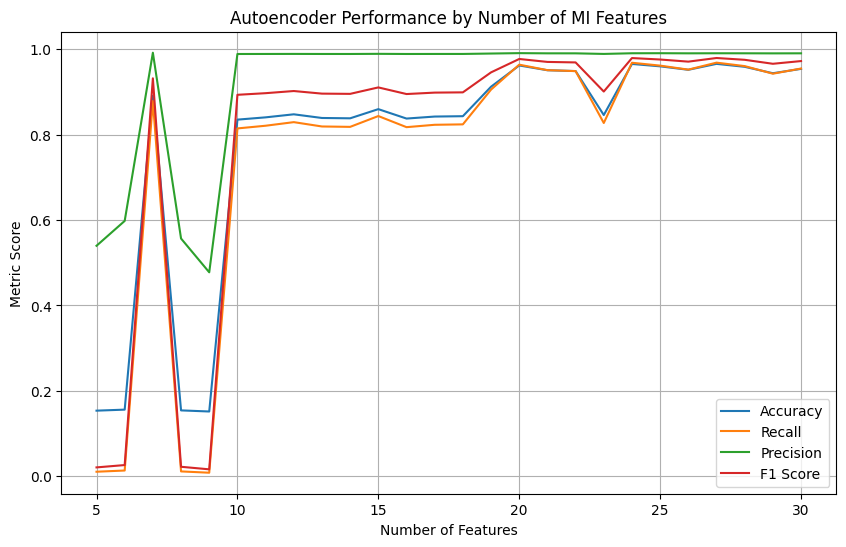

In [19]:
# Initialize lists to store results for the autoencoder
metrics_autoencoder = {'num_features': [], 'accuracy': [], 'recall': [], 'precision': [], 'f1': []}

# Iterate from 5 to 20 features
for num_features in range(5, 31):
    # Select the top features based on the current number
    selected_features = top_30_mi_features[:num_features]
    
    # Re-select the features from the original DataFrame each time in the loop
    features = df[selected_features]
    labels = df['Attack']
    
    # Normalize the features to range [0, 1]
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # Split the data into normal (Attack == 0) and attack (Attack == 1)
    normal_data = features_normalized[labels == 0]
    attack_data = features_normalized[labels == 1]

    # Split the normal data into training and validation sets
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

    # Use the attack data and remaining normal data as the test set
    X_test = np.vstack([X_val, attack_data])  # Test set includes both normal and attack data
    y_test = np.hstack([np.zeros(len(X_val)), np.ones(len(attack_data))])  # 0 for normal, 1 for attack

    # Define the autoencoder architecture for the subset of features
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    # Build the autoencoder layers (encoder and decoder as previously defined)
    encoder = Dense(256)(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(128)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(64)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(32)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    encoder = Dense(16)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)

    decoder = Dense(32)(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(64)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(128)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    decoder = Dense(256)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)

    output_layer = Dense(input_dim, activation='sigmoid')(decoder)
    
    # Compile the autoencoder
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    # Train the autoencoder with a reduced number of epochs for testing
    initial_epochs = 30
    autoencoder.fit(X_train, X_train,
                    epochs=initial_epochs,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0)

    # Set the threshold based on reconstruction error in the validation set
    reconstructions_val = autoencoder.predict(X_val)
    reconstruction_errors_val = np.mean(np.power(X_val - reconstructions_val, 2), axis=1)
    threshold = np.percentile(reconstruction_errors_val, 95)  # 95th percentile

    # Evaluate performance on the test set
    reconstructions_test = autoencoder.predict(X_test)
    reconstruction_errors_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

    # Classify as anomaly if error > threshold
    y_pred_test = (reconstruction_errors_test > threshold).astype(int)

    # Calculate metrics for this number of features
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, zero_division=1)
    precision = precision_score(y_test, y_pred_test, zero_division=1)
    f1 = f1_score(y_test, y_pred_test, zero_division=1)
    
    # Append results to metrics dictionary
    metrics_autoencoder['num_features'].append(num_features)
    metrics_autoencoder['accuracy'].append(accuracy)
    metrics_autoencoder['recall'].append(recall)
    metrics_autoencoder['precision'].append(precision)
    metrics_autoencoder['f1'].append(f1)

# Convert metrics dictionary to a DataFrame for easier plotting
metrics_autoencoder_df = pd.DataFrame(metrics_autoencoder)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['accuracy'], label='Accuracy')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['recall'], label='Recall')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['precision'], label='Precision')
plt.plot(metrics_autoencoder_df['num_features'], metrics_autoencoder_df['f1'], label='F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('Metric Score')
plt.title('Autoencoder Performance by Number of MI Features')
plt.legend()
plt.grid(True)
plt.savefig('Autoencoder_MI_Nmbr_of_Features_Chart.png', bbox_inches='tight')
plt.show()


In [89]:
print(df['Attack'])

0         0
1         0
2         0
3         0
4         0
         ..
209954    1
209955    1
209956    1
209957    1
209958    1
Name: Attack, Length: 209959, dtype: int64


## Standardising data for autoencoder training

In [ ]:
# Subset features for PCC, RFE, and MI with the specified number of features
AE_pcc_features = df[list(top_30_pcc_features[:18]) + ['Attack']]  # First 18 features + 'Attack'
AE_rfe_features = df[list(top_30_rfe_features[:22]) + ['Attack']]  # First 22 features + 'Attack'
AE_mi_features = df[list(top_30_mi_features[:20]) + ['Attack']]    # First 20 features + 'Attack'
AE_base_features = df  # Include all features, 'Attack' is already included

# Updated Data Splitting Loop
data_splits = {}  # Initialize dictionary to store data splits

for method_name, AE_features in [
    ("AE_Base", AE_base_features),
    ("AE_MI", AE_mi_features),
    ("AE_PCC", AE_pcc_features),
    ("AE_RFE", AE_rfe_features)
]:
    # Separate features and target explicitly
    labels = AE_features['Attack'].values  # Extract labels
    features = AE_features.drop(columns=['Attack'])  # Remove 'Attack' from the feature set

    # Separate normal and attack data
    normal_data = features[labels == 0]
    attack_data = features[labels == 1]

    # Debugging feature presence
    print(f"{method_name}: Normal data shape: {normal_data.shape}, Attack data shape: {attack_data.shape}")

    # Standardize the data using MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler only on normal and attack data
    normal_data_scaled = scaler.fit_transform(normal_data)
    attack_data_scaled = scaler.transform(attack_data)

    # Split normal data into training, validation, and test sets
    X_train_normal, X_temp_normal = train_test_split(normal_data_scaled, test_size=0.36, random_state=42)
    X_val_normal, X_test_normal = train_test_split(X_temp_normal, test_size=0.56, random_state=42)

    # Split attack data into validation and test sets
    X_val_attack, X_test_attack = train_test_split(attack_data_scaled, test_size=0.56, random_state=42)

    # Combine normal and attack data for validation and test sets
    X_val = np.vstack([X_val_normal, X_val_attack])
    X_test = np.vstack([X_test_normal, X_test_attack])
    y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_val_attack))])
    y_test = np.hstack([np.zeros(len(X_test_normal)), np.ones(len(X_test_attack))])

    # Store the splits
    data_splits[method_name] = {
        "X_train": X_train_normal,
        "X_val": X_val,
        "X_test": X_test,
        "y_val": y_val,
        "y_test": y_test
    }

    print(f"Data preparation completed for {method_name} features.")


AE_Base: Normal data shape: (99349, 62), Attack data shape: (110610, 62)
Data preparation completed for AE_Base features.
AE_MI: Normal data shape: (99349, 20), Attack data shape: (110610, 20)
Data preparation completed for AE_MI features.
AE_PCC: Normal data shape: (99349, 18), Attack data shape: (110610, 18)
Data preparation completed for AE_PCC features.
AE_RFE: Normal data shape: (99349, 22), Attack data shape: (110610, 22)
Data preparation completed for AE_RFE features.


# auto encoder final models

In [178]:
# Function to calculate autoencoder complexity
def calculate_autoencoder_complexity(layers):
    total_complexity = 0
    
    for i in range(len(layers) - 1):
        n_neurons_current = layers[i + 1]
        n_neurons_previous = layers[i]
        
        # Complexity for this layer
        layer_complexity = n_neurons_current * (n_neurons_previous + 1)  # +1 accounts for the bias
        total_complexity += layer_complexity
    
    return total_complexity

## Base auto-encoder

### Prep data

In [210]:
# Separate normal and attack data
normal_data_base = df[df['Attack'] == 0]
attack_data_base = df[df['Attack'] == 1]

# drop label column since it is not needed
normal_data_base.drop('Attack', axis = 1, inplace=True)
attack_data_base.drop('Attack', axis = 1, inplace=True)

# Standardize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on normal and attack data
normal_data_base_scaled = scaler.fit_transform(normal_data_base)
attack_data_base_scaled = scaler.transform(attack_data_base)

# Split normal data into train and validation
x_good_base_train, x_good_base_val = train_test_split(normal_data_base_scaled, test_size=0.25, random_state=42)

print(f"Good train count: {len(x_good_base_train)}")
print(f"Good test count: {len(x_good_base_val)}")


Good train count: 74511
Good test count: 24838


/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/605661872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data_base.drop('Attack', axis = 1, inplace=True)
/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/605661872.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data_base.drop('Attack', axis = 1, inplace=True)


### Configure layers and learning rate

In [211]:
# Define possible configurations
layer_configs = [
    [63, 30, 14, 6, 14, 30, 63],  # Original configuration
    [63, 40, 20, 10, 20, 40, 63],  # Wider layers
    [63, 20, 10, 5, 10, 20, 63],   # Narrower layers
    [63, 50, 25, 12, 25, 50, 63]   # Deeper network
]
learning_rates = [1e-2, 1e-3, 1e-4]

# Placeholder for results
results = []

# Loop through layer configurations and learning rates
for layers in layer_configs:
    for lr in learning_rates:
        print(f"Testing configuration: Layers={layers}, Learning Rate={lr}")
        
        # Build the model
        model = Sequential()
        model.add(Dense(layers[0], input_dim=x_good_base_train.shape[1], activation='relu'))
        for neurons in layers[1:]:
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(x_good_base_train.shape[1]))  # Output layer
        
        # Compile the model
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        
        # Train the model
        model.fit(x_good_base_train, x_good_base_train, verbose=0, epochs=25)
        
        # Evaluate the model
        pred_train = model.predict(x_good_base_val)
        score_train = np.sqrt(mean_squared_error(pred_train, x_good_base_val))
        
        pred_good_test = model.predict(normal_data_base_scaled)
        score_good_test = np.sqrt(mean_squared_error(pred_good_test, normal_data_base_scaled))
        
        pred_bad_test = model.predict(attack_data_base_scaled)
        score_bad_test = np.sqrt(mean_squared_error(pred_bad_test, attack_data_base_scaled))
        
        # Save the results
        results.append({
            'layers': layers,
            'learning_rate': lr,
            'train_rmse': score_train,
            'good_test_rmse': score_good_test,
            'bad_test_rmse': score_bad_test
        })
        
        # Print current results
        print(f"Train RMSE: {score_train}, Good Test RMSE: {score_good_test}, Bad Test RMSE: {score_bad_test}")

# Display all results
results_df = pd.DataFrame(results)
results_df.sort_values(by='bad_test_rmse', ascending=False, inplace=True)
print(results_df)


Testing configuration: Layers=[63, 30, 14, 6, 14, 30, 63], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step
Train RMSE: 0.04271876656350221, Good Test RMSE: 0.042415664450525276, Bad Test RMSE: 3.5754758326539537
Testing configuration: Layers=[63, 30, 14, 6, 14, 30, 63], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
Train RMSE: 0.013852297706069204, Good Test RMSE: 0.013673827866094081, Bad Test RMSE: 3.6165446765629836
Testing configuration: Layers=[63, 30, 14, 6, 14, 30, 63], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step
Train RMSE: 0.019860075776198416, Good Test RMSE: 0.019627515346894726, Bad Test RMSE: 3.604769388561026
Testing configuration: Layers=[63, 40, 20, 10, 20, 40, 63], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
Train RMSE: 0.06878647686411699, Good Test RMSE: 0.06853021280353662, Bad Test RMSE: 3.5708860799777544
Testing configuration: Layers=[63, 40, 20, 10, 20, 40, 63], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step
Train RMSE: 0.009069014948603132, Good Test RMSE: 0.008817474139333517, Bad Test RMSE: 3.6004040111649136
Testing configuration: Layers=[63, 40, 20, 10, 20, 40, 63], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step
Train RMSE: 0.015394446904200564, Good Test RMSE: 0.015147688916639071, Bad Test RMSE: 3.609413634278983
Testing configuration: Layers=[63, 20, 10, 5, 10, 20, 63], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step
Train RMSE: 0.032510245037047365, Good Test RMSE: 0.03231024053366843, Bad Test RMSE: 3.589088311207988
Testing configuration: Layers=[63, 20, 10, 5, 10, 20, 63], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step
Train RMSE: 0.019869857737549085, Good Test RMSE: 0.019637313688053916, Bad Test RMSE: 3.5755726742848313
Testing configuration: Layers=[63, 20, 10, 5, 10, 20, 63], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step
Train RMSE: 0.025424161738740743, Good Test RMSE: 0.02511649551997414, Bad Test RMSE: 3.6293331222755167
Testing configuration: Layers=[63, 50, 25, 12, 25, 50, 63], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step
Train RMSE: 0.0563474559297837, Good Test RMSE: 0.056296888994822526, Bad Test RMSE: 3.5702923965060953
Testing configuration: Layers=[63, 50, 25, 12, 25, 50, 63], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
Train RMSE: 0.010985673329431893, Good Test RMSE: 0.010679072989869398, Bad Test RMSE: 3.5834700578639946
Testing configuration: Layers=[63, 50, 25, 12, 25, 50, 63], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step
Train RMSE: 0.01291481700302048, Good Test RMSE: 0.012664563359875678, Bad Test RMSE: 3.593616869046988
                          layers  learning_rate  train_rmse  good_test_rmse  \
8    [63, 20, 10, 5, 10, 20, 63]         0.0001    0.025424        0.025116   
1    [63, 30, 14, 6, 14, 30, 63]         0.0010    0.013852        0.013674   
5   [63, 40, 20, 10, 20, 40, 63]         0.0001    0.015394        0.015148   
2    [63, 30, 14, 6, 14, 30, 63]         0.0001    0.019860        0.019628   
4   [63, 40, 20, 10, 20, 40, 63]         0.0010    0.009069        0.008817   
11  [63, 50, 25, 12, 25, 50, 63]         0.0001    0.012915        0.012665   
6    [63, 20, 10, 5, 10, 20, 63]         0.0100    0.032510        0.032310   
10  [63, 50, 25, 12, 25, 50, 63]         0.0010    0.010986        0.010679   
7    [63, 20, 10, 5, 10, 20, 63]         0.0010    0

### Configure the threshold for best F1

In [212]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Chosen configuration
optimal_layers = [63, 20, 10, 5, 10, 20, 63]
optimal_lr = 0.0001

# Define the model
model = Sequential()
model.add(Dense(optimal_layers[0], input_dim=x_good_base_train.shape[1], activation='relu'))

# Add hidden layers with dropout
for neurons in optimal_layers[1:]:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.3))  # 30% dropout

model.add(Dense(x_good_base_train.shape[1]))  # Output layer matches input dimensions

# Compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_good_base_train,
    x_good_base_train,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

# Reconstruction errors
reconstruction_errors_good = np.sqrt(np.mean((model.predict(normal_data_base_scaled) - normal_data_base_scaled) ** 2, axis=1))
reconstruction_errors_bad = np.sqrt(np.mean((model.predict(attack_data_base_scaled) - attack_data_base_scaled) ** 2, axis=1))

# Define threshold as mean + k*std
mean_good = np.mean(reconstruction_errors_good)
std_good = np.std(reconstruction_errors_good)

# Define threshold as mean + k*std
k = 1  # Example: 3 standard deviations
threshold = mean_good + k * std_good
print(f"Chosen Threshold: {threshold}")

# Classify anomalies
labels_good = np.zeros(len(reconstruction_errors_good))  # Normal data
labels_bad = np.ones(len(reconstruction_errors_bad))    # Attack data
labels_pred_good = (reconstruction_errors_good > threshold).astype(int)
labels_pred_bad = (reconstruction_errors_bad > threshold).astype(int)

# Combine for evaluation
y_true = np.concatenate([labels_good, labels_bad])
y_pred = np.concatenate([labels_pred_good, labels_pred_bad])

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

classification_report_str = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("\nClassification Report:")
print(classification_report_str)


Epoch 1/50


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2329/2329 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - loss: 0.0335
Epoch 2/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.0143
Epoch 3/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - loss: 0.0116
Epoch 4/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 0.0099
Epoch 5/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - loss: 0.0090
Epoch 6/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 0.0085
Epoch 7/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.0081
Epoch 8/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.0077
Epoch 9/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.0073
Epoch 10/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.0071
Epoch 11/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - loss: 0.0069
Epoch 12/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.0067
Epoch 13/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - loss: 0.0066
Epoch 14/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - loss: 0.0065
Epoch 15/50


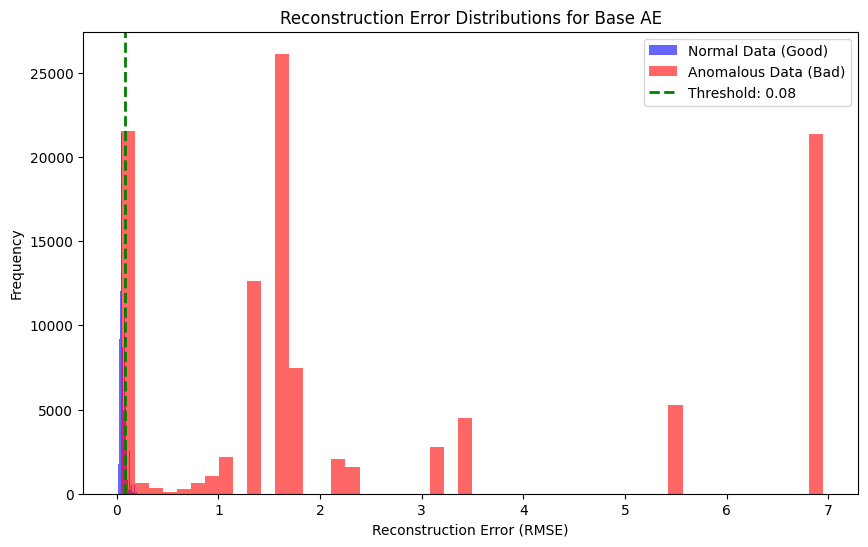

In [213]:
# Plot RMSE distributions
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_good, bins=50, alpha=0.6, label='Normal Data (Good)', color='blue')
plt.hist(reconstruction_errors_bad, bins=50, alpha=0.6, label='Anomalous Data (Bad)', color='red')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error Distributions for Base AE')
plt.xlabel('Reconstruction Error (RMSE)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Autoencoder_Base_ReconstructionError_and_Threshold.png', bbox_inches='tight')
plt.show()


In [216]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[86969 12380]
 [12811 97799]]


In [217]:
# Calculate complexity
autoencoder_complexity = calculate_autoencoder_complexity(optimal_layers)

print(f"Autoencoder Complexity (Single Prediction): {autoencoder_complexity} computations")

Autoencoder Complexity (Single Prediction): 3148 computations


## PCC auto-encoder

### Prep data

In [218]:
# Separate normal and attack data
normal_data_pcc = AE_pcc_features[AE_pcc_features['Attack'] == 0]
attack_data_pcc = AE_pcc_features[AE_pcc_features['Attack'] == 1]

# drop label column since it is not needed
normal_data_pcc.drop('Attack', axis = 1, inplace=True)
attack_data_pcc.drop('Attack', axis = 1, inplace=True)

# Standardize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on normal and attack data
normal_data_pcc_scaled = scaler.fit_transform(normal_data_pcc)
attack_data_pcc_scaled = scaler.transform(attack_data_pcc)

# Split normal data into train and validation
x_good_pcc_train, x_good_pcc_val = train_test_split(normal_data_pcc_scaled, test_size=0.25, random_state=42)

print(f"Good train count: {len(x_good_pcc_train)}")
print(f"Good test count: {len(x_good_pcc_val)}")


Good train count: 74511
Good test count: 24838


/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/3684637478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data_pcc.drop('Attack', axis = 1, inplace=True)
/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/3684637478.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data_pcc.drop('Attack', axis = 1, inplace=True)


### Configure layers and learning rate

In [219]:
# Define possible configurations
layer_configs_pcc = [
    [18, 9, 5, 9, 18],       # Original PCC configuration (based on reduced feature set)
    [18, 12, 6, 12, 18],     # Wider layers for PCC
    [18, 6, 3, 6, 18],       # Narrower layers for PCC
    [18, 15, 8, 15, 18]      # Deeper network for PCC
]
learning_rates = [1e-2, 1e-3, 1e-4]

# Placeholder for results
results_pcc = []

# Loop through layer configurations and learning rates
for layers in layer_configs_pcc:
    for lr in learning_rates:
        print(f"Testing configuration: Layers={layers}, Learning Rate={lr}")
        
        # Build the model
        model = Sequential()
        model.add(Dense(layers[0], input_dim=x_good_pcc_train.shape[1], activation='relu'))
        for neurons in layers[1:]:
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(x_good_pcc_train.shape[1]))  # Output layer
        
        # Compile the model
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        
        # Train the model
        model.fit(x_good_pcc_train, x_good_pcc_train, verbose=0, epochs=25)
        
        # Evaluate the model
        pred_train = model.predict(x_good_pcc_val)
        score_train = np.sqrt(mean_squared_error(pred_train, x_good_pcc_val))
        
        pred_good_test = model.predict(normal_data_pcc_scaled)
        score_good_test = np.sqrt(mean_squared_error(pred_good_test, normal_data_pcc_scaled))
        
        pred_bad_test = model.predict(attack_data_pcc_scaled)
        score_bad_test = np.sqrt(mean_squared_error(pred_bad_test, attack_data_pcc_scaled))
        
        # Save the results
        results_pcc.append({
            'layers': layers,
            'learning_rate': lr,
            'train_rmse': score_train,
            'good_test_rmse': score_good_test,
            'bad_test_rmse': score_bad_test
        })
        
        # Print current results
        print(f"Train RMSE: {score_train}, Good Test RMSE: {score_good_test}, Bad Test RMSE: {score_bad_test}")

# Display all results
import pandas as pd
results_df = pd.DataFrame(results_pcc)
results_df.sort_values(by='bad_test_rmse', ascending=False, inplace=True)
print(results_df)

Testing configuration: Layers=[18, 9, 5, 9, 18], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
Train RMSE: 0.05091937819094464, Good Test RMSE: 0.05071792332724124, Bad Test RMSE: 6.624820832087586
Testing configuration: Layers=[18, 9, 5, 9, 18], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
Train RMSE: 0.012338462128611862, Good Test RMSE: 0.012079630412629681, Bad Test RMSE: 6.554431259900724
Testing configuration: Layers=[18, 9, 5, 9, 18], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
Train RMSE: 0.0141583310068204, Good Test RMSE: 0.01388290600047317, Bad Test RMSE: 6.834921640554333
Testing configuration: Layers=[18, 12, 6, 12, 18], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
Train RMSE: 0.01570907482499907, Good Test RMSE: 0.01539538104862647, Bad Test RMSE: 6.595916466315727
Testing configuration: Layers=[18, 12, 6, 12, 18], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
Train RMSE: 0.010316160768047929, Good Test RMSE: 0.009806845328155147, Bad Test RMSE: 6.197121074491744
Testing configuration: Layers=[18, 12, 6, 12, 18], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
Train RMSE: 0.009770784720899843, Good Test RMSE: 0.009428544156250666, Bad Test RMSE: 6.702779624980203
Testing configuration: Layers=[18, 6, 3, 6, 18], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
Train RMSE: 0.16856617408300423, Good Test RMSE: 0.16830985952044505, Bad Test RMSE: 6.734034549513045
Testing configuration: Layers=[18, 6, 3, 6, 18], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step
Train RMSE: 0.03553229184300019, Good Test RMSE: 0.03521640458257065, Bad Test RMSE: 6.609040441630697
Testing configuration: Layers=[18, 6, 3, 6, 18], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
Train RMSE: 0.036949061617221744, Good Test RMSE: 0.03675248329587208, Bad Test RMSE: 6.75355064298395
Testing configuration: Layers=[18, 15, 8, 15, 18], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step
Train RMSE: 0.026950700352220264, Good Test RMSE: 0.026764592515127836, Bad Test RMSE: 6.628050514739544
Testing configuration: Layers=[18, 15, 8, 15, 18], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
Train RMSE: 0.00550194131025552, Good Test RMSE: 0.004859002534811615, Bad Test RMSE: 5.726578273906841
Testing configuration: Layers=[18, 15, 8, 15, 18], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Train RMSE: 0.015028149436994646, Good Test RMSE: 0.014773241418186636, Bad Test RMSE: 6.733783549948784
                 layers  learning_rate  train_rmse  good_test_rmse  \
2     [18, 9, 5, 9, 18]         0.0001    0.014158        0.013883   
8     [18, 6, 3, 6, 18]         0.0001    0.036949        0.036752   
6     [18, 6, 3, 6, 18]         0.0100    0.168566        0.168310   
11  [18, 15, 8, 15, 18]         0.0001    0.015028        0.014773   
5   [18, 12, 6, 12, 18]         0.0001    0.009771        0.009429   
9   [18, 15, 8, 15, 18]         0.0100    0.026951        0.026765   
0     [18, 9, 5, 9, 18]         0.0100    0.050919        0.050718   
7     [18, 6, 3, 6, 18]         0.0010    0.035532        0.035216   
3   [18, 12, 6, 12, 18]         0.0100    0.015709        0.015395   
1     [18, 9, 5, 9, 18]         0.0010    0.012338        0.0120

### Configure the threshold for best F1

In [220]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Chosen configuration
optimal_layers = [18, 9, 5, 9, 18]
optimal_lr = 0.0001

# Define the model
model = Sequential()
model.add(Dense(optimal_layers[0], input_dim=x_good_pcc_train.shape[1], activation='relu'))

# Add hidden layers with dropout
for neurons in optimal_layers[1:]:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.3))  # 30% dropout

model.add(Dense(x_good_pcc_train.shape[1]))  # Output layer matches input dimensions

# Compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_good_pcc_train,
    x_good_pcc_train,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

# Reconstruction errors
reconstruction_errors_good = np.sqrt(np.mean((model.predict(normal_data_pcc_scaled) - normal_data_pcc_scaled) ** 2, axis=1))
reconstruction_errors_bad = np.sqrt(np.mean((model.predict(attack_data_pcc_scaled) - attack_data_pcc_scaled) ** 2, axis=1))

# Define threshold as mean + k*std
mean_good = np.mean(reconstruction_errors_good)
std_good = np.std(reconstruction_errors_good)

# Define threshold as mean + k*std
k = 1  # Example: 3 standard deviations
threshold = mean_good + k * std_good
print(f"Chosen Threshold: {threshold}")

# Classify anomalies
labels_good = np.zeros(len(reconstruction_errors_good))  # Normal data
labels_bad = np.ones(len(reconstruction_errors_bad))    # Attack data
labels_pred_good = (reconstruction_errors_good > threshold).astype(int)
labels_pred_bad = (reconstruction_errors_bad > threshold).astype(int)

# Combine for evaluation
y_true = np.concatenate([labels_good, labels_bad])
y_pred = np.concatenate([labels_pred_good, labels_pred_bad])

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

classification_report_str = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("\nClassification Report:")
print(classification_report_str)


Epoch 1/50


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2329/2329 ━━━━━━━━━━━━━━━━━━━━ 2s 453us/step - loss: 0.0644
Epoch 2/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.0181
Epoch 3/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.0128
Epoch 4/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - loss: 0.0110
Epoch 5/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - loss: 0.0101
Epoch 6/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 0.0097
Epoch 7/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 0.0096
Epoch 8/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - loss: 0.0093
Epoch 9/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - loss: 0.0092
Epoch 10/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - loss: 0.0091
Epoch 11/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 0.0089
Epoch 12/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - loss: 0.0088
Epoch 13/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - loss: 0.0086
Epoch 14/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.0086
Epoch 15/50


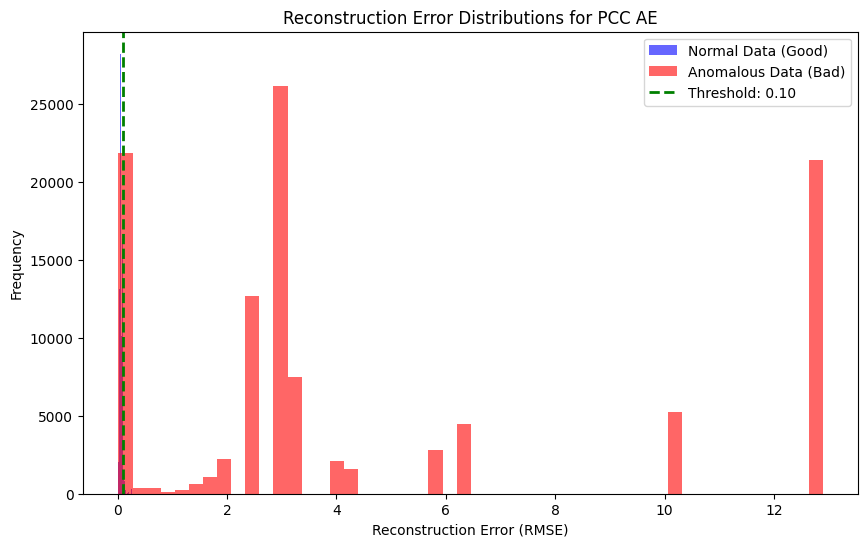

In [221]:
# Plot RMSE distributions
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_good, bins=50, alpha=0.6, label='Normal Data (Good)', color='blue')
plt.hist(reconstruction_errors_bad, bins=50, alpha=0.6, label='Anomalous Data (Bad)', color='red')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error Distributions for PCC AE')
plt.xlabel('Reconstruction Error (RMSE)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Autoencoder_PCC_ReconstructionError_and_Threshold.png', bbox_inches='tight')
plt.show()


In [222]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[91322  8027]
 [19983 90627]]


In [223]:
# Calculate complexity
autoencoder_complexity = calculate_autoencoder_complexity(optimal_layers)

print(f"Autoencoder Complexity (Single Prediction): {autoencoder_complexity} computations")

Autoencoder Complexity (Single Prediction): 455 computations


## RFE auto-encoder

### Prep data

In [228]:
# Separate normal and attack data
normal_data_rfe = AE_rfe_features[AE_rfe_features['Attack'] == 0]
attack_data_rfe = AE_rfe_features[AE_rfe_features['Attack'] == 1]

# drop label column since it is not needed
normal_data_rfe.drop('Attack', axis = 1, inplace=True)
attack_data_rfe.drop('Attack', axis = 1, inplace=True)

# Standardize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on normal and attack data
normal_data_rfe_scaled = scaler.fit_transform(normal_data_rfe)
attack_data_rfe_scaled = scaler.transform(attack_data_rfe)

# Split normal data into train and validation
x_good_rfe_train, x_good_rfe_val = train_test_split(normal_data_rfe_scaled, test_size=0.25, random_state=42)

print(f"Good train count: {len(x_good_rfe_train)}")
print(f"Good test count: {len(x_good_rfe_val)}")


Good train count: 74511
Good test count: 24838


/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/1635975361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data_rfe.drop('Attack', axis = 1, inplace=True)
/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/1635975361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data_rfe.drop('Attack', axis = 1, inplace=True)


### Configure layers and learning rate

In [230]:
# Define possible configurations
layer_configs_rfe = [
    [22, 11, 5, 11, 22],       # Original RFE configuration (based on reduced feature set)
    [22, 16, 8, 16, 22],       # Wider layers for RFE
    [22, 8, 4, 8, 22],         # Narrower layers for RFE
    [22, 18, 9, 18, 22]        # Deeper network for RFE
]
learning_rates = [1e-2, 1e-3, 1e-4]

# Placeholder for results
results_rfe = []

# Loop through layer configurations and learning rates
for layers in layer_configs_rfe:
    for lr in learning_rates:
        print(f"Testing configuration: Layers={layers}, Learning Rate={lr}")
        
        # Build the model
        model = Sequential()
        model.add(Dense(layers[0], input_dim=x_good_rfe_train.shape[1], activation='relu'))
        for neurons in layers[1:]:
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(x_good_rfe_train.shape[1]))  # Output layer
        
        # Compile the model
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        
        # Train the model
        model.fit(x_good_rfe_train, x_good_rfe_train, verbose=0, epochs=25)
        
        # Evaluate the model
        pred_train = model.predict(x_good_rfe_val)
        score_train = np.sqrt(mean_squared_error(pred_train, x_good_rfe_val))
        
        pred_good_test = model.predict(normal_data_rfe_scaled)
        score_good_test = np.sqrt(mean_squared_error(pred_good_test, normal_data_rfe_scaled))
        
        pred_bad_test = model.predict(attack_data_rfe_scaled)
        score_bad_test = np.sqrt(mean_squared_error(pred_bad_test, attack_data_rfe_scaled))
        
        # Save the results
        results_rfe.append({
            'layers': layers,
            'learning_rate': lr,
            'train_rmse': score_train,
            'good_test_rmse': score_good_test,
            'bad_test_rmse': score_bad_test
        })
        
        # Print current results
        print(f"Train RMSE: {score_train}, Good Test RMSE: {score_good_test}, Bad Test RMSE: {score_bad_test}")

# Display all results
import pandas as pd
results_df = pd.DataFrame(results_rfe)
results_df.sort_values(by='bad_test_rmse', ascending=False, inplace=True)
print(results_df)


Testing configuration: Layers=[22, 11, 5, 11, 22], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step
Train RMSE: 0.02176252052125813, Good Test RMSE: 0.021454624421801224, Bad Test RMSE: 0.03295019215500831
Testing configuration: Layers=[22, 11, 5, 11, 22], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step
Train RMSE: 0.025982028018991448, Good Test RMSE: 0.02562549180090089, Bad Test RMSE: 0.04205327962769936
Testing configuration: Layers=[22, 11, 5, 11, 22], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 323us/step
Train RMSE: 0.01962830167076071, Good Test RMSE: 0.019383785621308398, Bad Test RMSE: 0.03424914118698917
Testing configuration: Layers=[22, 16, 8, 16, 22], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
Train RMSE: 0.02260897908848902, Good Test RMSE: 0.02237510307409677, Bad Test RMSE: 0.03293131120994501
Testing configuration: Layers=[22, 16, 8, 16, 22], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step
Train RMSE: 0.01165837386775508, Good Test RMSE: 0.011431039194810347, Bad Test RMSE: 0.021964178905293286
Testing configuration: Layers=[22, 16, 8, 16, 22], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
Train RMSE: 0.006587475385159677, Good Test RMSE: 0.006120646306470132, Bad Test RMSE: 0.02434535816134165
Testing configuration: Layers=[22, 8, 4, 8, 22], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
Train RMSE: 0.1339899767595454, Good Test RMSE: 0.13380254720336268, Bad Test RMSE: 0.18103086539264035
Testing configuration: Layers=[22, 8, 4, 8, 22], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
Train RMSE: 0.018726844612164697, Good Test RMSE: 0.01842742734303903, Bad Test RMSE: 0.03329626134220075
Testing configuration: Layers=[22, 8, 4, 8, 22], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
Train RMSE: 0.030438797537474416, Good Test RMSE: 0.029979214817518675, Bad Test RMSE: 0.04162606017032037
Testing configuration: Layers=[22, 18, 9, 18, 22], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step
Train RMSE: 0.021749331498804696, Good Test RMSE: 0.02159342881959844, Bad Test RMSE: 0.02996743491269559
Testing configuration: Layers=[22, 18, 9, 18, 22], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step
Train RMSE: 0.009353223917054553, Good Test RMSE: 0.008974425234701247, Bad Test RMSE: 0.028404182053988536
Testing configuration: Layers=[22, 18, 9, 18, 22], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
Train RMSE: 0.018975213017170492, Good Test RMSE: 0.018750142516891277, Bad Test RMSE: 0.03165580874281152
                 layers  learning_rate  train_rmse  good_test_rmse  \
6     [22, 8, 4, 8, 22]         0.0100    0.133990        0.133803   
1   [22, 11, 5, 11, 22]         0.0010    0.025982        0.025625   
8     [22, 8, 4, 8, 22]         0.0001    0.030439        0.029979   
2   [22, 11, 5, 11, 22]         0.0001    0.019628        0.019384   
7     [22, 8, 4, 8, 22]         0.0010    0.018727        0.018427   
0   [22, 11, 5, 11, 22]         0.0100    0.021763        0.021455   
3   [22, 16, 8, 16, 22]         0.0100    0.022609        0.022375   
11  [22, 18, 9, 18, 22]         0.0001    0.018975        0.018750   
9   [22, 18, 9, 18, 22]         0.0100    0.021749        0.021593   
10  [22, 18, 9, 18, 22]         0.0010    0.009353        0.

### Configure the threshold

In [245]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Chosen configuration
optimal_layers = [22, 8, 4, 8, 22]
optimal_lr = 0.01

# Define the model
model = Sequential()
model.add(Dense(optimal_layers[0], input_dim=x_good_rfe_train.shape[1], activation='relu'))

# Add hidden layers with dropout
for neurons in optimal_layers[1:]:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.3))  # 30% dropout

model.add(Dense(x_good_rfe_train.shape[1]))  # Output layer matches input dimensions

# Compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_good_rfe_train,
    x_good_rfe_train,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

# Reconstruction errors
reconstruction_errors_good = np.sqrt(np.mean((model.predict(normal_data_rfe_scaled) - normal_data_rfe_scaled) ** 2, axis=1))
reconstruction_errors_bad = np.sqrt(np.mean((model.predict(attack_data_rfe_scaled) - attack_data_rfe_scaled) ** 2, axis=1))

# Define threshold as mean + k*std
mean_good = np.mean(reconstruction_errors_good)
std_good = np.std(reconstruction_errors_good)

# Define threshold as mean + k*std
k = 0.25  
threshold = mean_good + k * std_good
print(f"Chosen Threshold: {threshold}")

# Classify anomalies
labels_good = np.zeros(len(reconstruction_errors_good))  # Normal data
labels_bad = np.ones(len(reconstruction_errors_bad))    # Attack data
labels_pred_good = (reconstruction_errors_good > threshold).astype(int)
labels_pred_bad = (reconstruction_errors_bad > threshold).astype(int)

# Combine for evaluation
y_true = np.concatenate([labels_good, labels_bad])
y_pred = np.concatenate([labels_pred_good, labels_pred_bad])

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

classification_report_str = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("\nClassification Report:")
print(classification_report_str)


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 3s 413us/step - loss: 0.0196
Epoch 2/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 0.0178
Epoch 3/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - loss: 0.0179
Epoch 4/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 0.0179
Epoch 5/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - loss: 0.0179
Epoch 6/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - loss: 0.0178
Epoch 7/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - loss: 0.0179
Epoch 8/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.0178
Epoch 9/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - loss: 0.0178
Epoch 10/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 0.0178
Epoch 11/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.0179
Epoch 12/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.0178
Epoch 13/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - loss: 0.0179
Epoch 14/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - loss: 0.0179
E

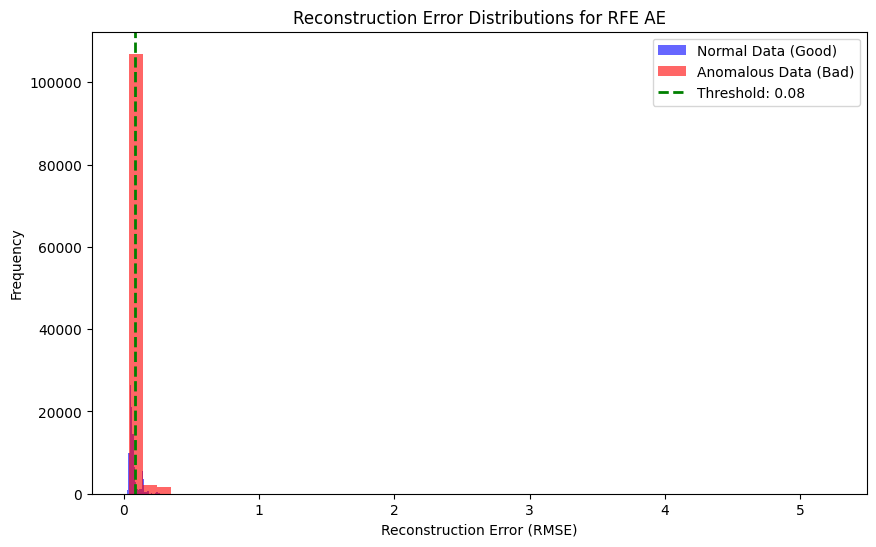

In [232]:
# Plot RMSE distributions
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_good, bins=50, alpha=0.6, label='Normal Data (Good)', color='blue')
plt.hist(reconstruction_errors_bad, bins=50, alpha=0.6, label='Anomalous Data (Bad)', color='red')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error Distributions for RFE AE')
plt.xlabel('Reconstruction Error (RMSE)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Autoencoder_RFE_ReconstructionError_and_Threshold.png', bbox_inches='tight')
plt.show()


In [246]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 67338  32011]
 [   216 110394]]


In [236]:
# Calculate complexity
autoencoder_complexity = calculate_autoencoder_complexity(optimal_layers)

print(f"Autoencoder Complexity (Single Prediction): {autoencoder_complexity} computations")

Autoencoder Complexity (Single Prediction): 458 computations


## MI auto-encoder

In [237]:
AE_mi_features = df[list(top_30_mi_features[:20]) + ['Attack']]    # First 20 features + 'Attack'

### Prep data

In [238]:
# Separate normal and attack data
normal_data_mi = AE_mi_features[AE_mi_features['Attack'] == 0]
attack_data_mi = AE_mi_features[AE_mi_features['Attack'] == 1]

# drop label column since it is not needed
normal_data_mi.drop('Attack', axis = 1, inplace=True)
attack_data_mi.drop('Attack', axis = 1, inplace=True)

# Standardize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on normal and attack data
normal_data_mi_scaled = scaler.fit_transform(normal_data_mi)
attack_data_mi_scaled = scaler.transform(attack_data_mi)

# Split normal data into train and validation
x_good_mi_train, x_good_mi_val = train_test_split(normal_data_mi_scaled, test_size=0.25, random_state=42)

print(f"Good train count: {len(x_good_mi_train)}")
print(f"Good test count: {len(x_good_mi_val)}")
print(x_good_mi_train.shape)


Good train count: 74511
Good test count: 24838
(74511, 20)


/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/15793599.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data_mi.drop('Attack', axis = 1, inplace=True)
/var/folders/b_/qhxstzcn53d8qqxjl2hdw_gh0000gn/T/ipykernel_2467/15793599.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data_mi.drop('Attack', axis = 1, inplace=True)


### Configure layers and learning rate

In [239]:
# Define possible configurations
layer_configs_mi = [
    [20, 11, 5, 11, 20],       # Original MI configuration (based on reduced feature set)
    [20, 15, 8, 15, 20],       # Wider layers for MI
    [20, 7, 3, 7, 20],         # Narrower layers for MI
    [20, 17, 9, 17, 20]        # Deeper network for MI
]

learning_rates = [1e-2, 1e-3, 1e-4]

# Placeholder for results
results_mi = []

# Loop through layer configurations and learning rates
for layers in layer_configs_mi:
    for lr in learning_rates:
        print(f"Testing configuration: Layers={layers}, Learning Rate={lr}")
        
        # Build the model
        model = Sequential()
        model.add(Dense(layers[0], input_dim=x_good_mi_train.shape[1], activation='relu'))
        for neurons in layers[1:]:
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(x_good_mi_train.shape[1]))  # Output layer
        
        # Compile the model
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        
        # Train the model
        model.fit(x_good_mi_train, x_good_mi_train, verbose=0, epochs=25)
        
        # Evaluate the model
        pred_train = model.predict(x_good_mi_val)
        score_train = np.sqrt(mean_squared_error(pred_train, x_good_mi_val))
        
        pred_good_test = model.predict(normal_data_mi_scaled)
        score_good_test = np.sqrt(mean_squared_error(pred_good_test, normal_data_mi_scaled))
        
        pred_bad_test = model.predict(attack_data_mi_scaled)
        score_bad_test = np.sqrt(mean_squared_error(pred_bad_test, attack_data_mi_scaled))
        
        # Save the results
        results_mi.append({
            'layers': layers,
            'learning_rate': lr,
            'train_rmse': score_train,
            'good_test_rmse': score_good_test,
            'bad_test_rmse': score_bad_test
        })
        
        # Print current results
        print(f"Train RMSE: {score_train}, Good Test RMSE: {score_good_test}, Bad Test RMSE: {score_bad_test}")

# Display all results
import pandas as pd
results_df = pd.DataFrame(results_mi)
results_df.sort_values(by='bad_test_rmse', ascending=False, inplace=True)
print(results_df)


Testing configuration: Layers=[20, 11, 5, 11, 20], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
Train RMSE: 0.010087190356918421, Good Test RMSE: 0.009727595344498258, Bad Test RMSE: 8.077041912707022
Testing configuration: Layers=[20, 11, 5, 11, 20], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step
Train RMSE: 0.007591026694876649, Good Test RMSE: 0.0072714301981100125, Bad Test RMSE: 5.373021747938041
Testing configuration: Layers=[20, 11, 5, 11, 20], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
Train RMSE: 0.014040885442835577, Good Test RMSE: 0.014041780087003337, Bad Test RMSE: 6.300884169131883
Testing configuration: Layers=[20, 15, 8, 15, 20], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
Train RMSE: 0.013601839284075854, Good Test RMSE: 0.013249176618337853, Bad Test RMSE: 6.3096181338079615
Testing configuration: Layers=[20, 15, 8, 15, 20], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
Train RMSE: 0.007753212830288839, Good Test RMSE: 0.007364133188495411, Bad Test RMSE: 4.098606603969615
Testing configuration: Layers=[20, 15, 8, 15, 20], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step
Train RMSE: 0.007379547447850016, Good Test RMSE: 0.007262454614665525, Bad Test RMSE: 6.359730915478797
Testing configuration: Layers=[20, 7, 3, 7, 20], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
Train RMSE: 0.015725214266285953, Good Test RMSE: 0.015757336218515123, Bad Test RMSE: 6.413272401433574
Testing configuration: Layers=[20, 7, 3, 7, 20], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step
Train RMSE: 0.013934276542261703, Good Test RMSE: 0.013730759487557224, Bad Test RMSE: 6.5068357761225055
Testing configuration: Layers=[20, 7, 3, 7, 20], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
Train RMSE: 0.01821391789349219, Good Test RMSE: 0.018209387390373203, Bad Test RMSE: 6.301498656269639
Testing configuration: Layers=[20, 17, 9, 17, 20], Learning Rate=0.01


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
Train RMSE: 0.012068909547463206, Good Test RMSE: 0.012108752717815316, Bad Test RMSE: 6.296330927959261
Testing configuration: Layers=[20, 17, 9, 17, 20], Learning Rate=0.001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step
Train RMSE: 0.005677406279338065, Good Test RMSE: 0.004962688989390867, Bad Test RMSE: 4.669535910111017
Testing configuration: Layers=[20, 17, 9, 17, 20], Learning Rate=0.0001


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
3105/3105 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step
3457/3457 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
Train RMSE: 0.006505753344054609, Good Test RMSE: 0.005996814537289975, Bad Test RMSE: 6.096534750615669
                 layers  learning_rate  train_rmse  good_test_rmse  \
0   [20, 11, 5, 11, 20]         0.0100    0.010087        0.009728   
7     [20, 7, 3, 7, 20]         0.0010    0.013934        0.013731   
6     [20, 7, 3, 7, 20]         0.0100    0.015725        0.015757   
5   [20, 15, 8, 15, 20]         0.0001    0.007380        0.007262   
3   [20, 15, 8, 15, 20]         0.0100    0.013602        0.013249   
8     [20, 7, 3, 7, 20]         0.0001    0.018214        0.018209   
2   [20, 11, 5, 11, 20]         0.0001    0.014041        0.014042   
9   [20, 17, 9, 17, 20]         0.0100    0.012069        0.012109   
11  [20, 17, 9, 17, 20]         0.0001    0.006506        0.005997   
1   [20, 11, 5, 11, 20]         0.0010    0.007591        0.00

### Configure the threshold for best F1

In [241]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Chosen configuration
optimal_layers = [20, 11, 5, 11, 20]
optimal_lr = 0.01

# Define the model
model = Sequential()
model.add(Dense(optimal_layers[0], input_dim=x_good_mi_train.shape[1], activation='relu'))

# Add hidden layers with dropout
for neurons in optimal_layers[1:]:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.3))  # 30% dropout

model.add(Dense(x_good_mi_train.shape[1]))  # Output layer matches input dimensions

# Compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_good_mi_train,
    x_good_mi_train,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

# Reconstruction errors
reconstruction_errors_good = np.sqrt(np.mean((model.predict(normal_data_mi_scaled) - normal_data_mi_scaled) ** 2, axis=1))
reconstruction_errors_bad = np.sqrt(np.mean((model.predict(attack_data_mi_scaled) - attack_data_mi_scaled) ** 2, axis=1))

# Define threshold as mean + k*std
mean_good = np.mean(reconstruction_errors_good)
std_good = np.std(reconstruction_errors_good)

# Define threshold as mean + k*std
k = 1  # Example: 3 standard deviations
threshold = mean_good + k * std_good
print(f"Chosen Threshold: {threshold}")

# Classify anomalies
labels_good = np.zeros(len(reconstruction_errors_good))  # Normal data
labels_bad = np.ones(len(reconstruction_errors_bad))    # Attack data
labels_pred_good = (reconstruction_errors_good > threshold).astype(int)
labels_pred_bad = (reconstruction_errors_bad > threshold).astype(int)

# Combine for evaluation
y_true = np.concatenate([labels_good, labels_bad])
y_pred = np.concatenate([labels_pred_good, labels_pred_bad])

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

classification_report_str = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("\nClassification Report:")
print(classification_report_str)


Epoch 1/50


/Users/floris/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2329/2329 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step - loss: 0.0151
Epoch 2/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 0.0101
Epoch 3/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - loss: 0.0101
Epoch 4/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step - loss: 0.0101
Epoch 5/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - loss: 0.0100
Epoch 6/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - loss: 0.0100
Epoch 7/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - loss: 0.0100
Epoch 8/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.0100
Epoch 9/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - loss: 0.0099
Epoch 10/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - loss: 0.0098
Epoch 11/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - loss: 0.0099
Epoch 12/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - loss: 0.0090
Epoch 13/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - loss: 0.0088
Epoch 14/50
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - loss: 0.0088
Epoch 15/50


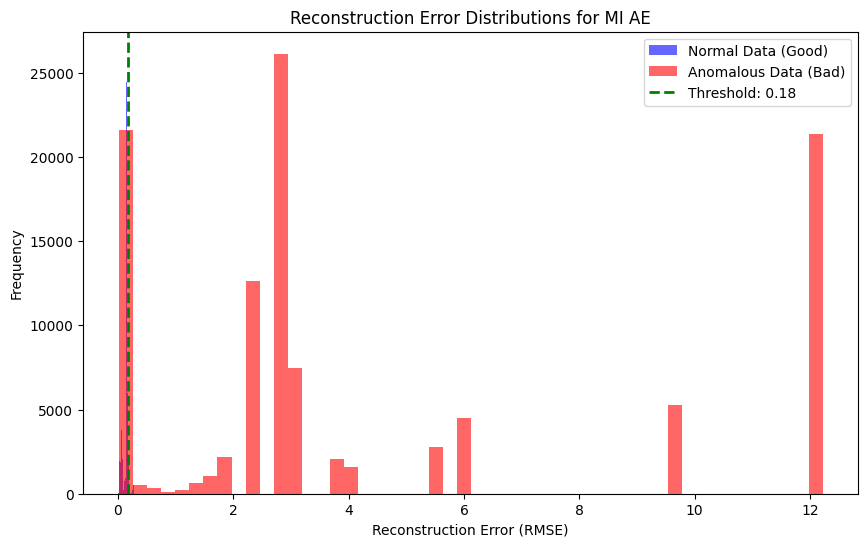

In [242]:
# Plot RMSE distributions
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_good, bins=50, alpha=0.6, label='Normal Data (Good)', color='blue')
plt.hist(reconstruction_errors_bad, bins=50, alpha=0.6, label='Anomalous Data (Bad)', color='red')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error Distributions for MI AE')
plt.xlabel('Reconstruction Error (RMSE)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Autoencoder_MI_ReconstructionError_and_Threshold.png', bbox_inches='tight')
plt.show()


In [243]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[95115  4234]
 [20735 89875]]


In [244]:
# Calculate complexity
autoencoder_complexity = calculate_autoencoder_complexity(optimal_layers)

print(f"Autoencoder Complexity (Single Prediction): {autoencoder_complexity} computations")

Autoencoder Complexity (Single Prediction): 597 computations


## Hyper tune RF (Depth)

In [58]:
X = df.drop('Attack', axis=1)  # All columns except the target
y = df['Attack']               # The target column only

# Split into Train Validation and Test sets

# First split: 85% train+validation, 15% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

# Second split: 70% train, 15% validation from the train+validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, shuffle=True) # 0.1765 is approximately 15% of the 85% that was originally taken for train+validation 

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Define depth range
depth_range = range(1, 21)

# Dictionary to store metrics for each subset
metrics_dicts = {
    "Base": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "MI": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "RFE": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "PCC": {"accuracy": [], "precision": [], "recall": [], "f1": []}
}

# Function to optimize Random Forest depth and store metrics for a given dataset and label
def optimize_rf_depth(X_train, X_val, y_train, y_val, X_test, y_test, subset_label):
    for depth in depth_range:
        # Train Random Forest with current depth
        model = RandomForestClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        
        # Validate on the validation set
        y_pred_val = model.predict(X_val)
        
        # Evaluate on the test set
        y_pred_test = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        # Append metrics to the corresponding subset dictionary
        metrics_dicts[subset_label]["accuracy"].append(accuracy)
        metrics_dicts[subset_label]["precision"].append(precision)
        metrics_dicts[subset_label]["recall"].append(recall)
        metrics_dicts[subset_label]["f1"].append(f1)

# Run optimization for each dataset
optimize_rf_depth(X_train, X_val, y_train, y_val, X_test, y_test, "Base")
optimize_rf_depth(RF_X_train_MI, RF_X_val_MI, y_train, y_val, RF_X_test_MI, y_test, "MI")
optimize_rf_depth(RF_X_train_RFE, RF_X_val_RFE, y_train, y_val, RF_X_test_RFE, y_test, "RFE")
optimize_rf_depth(RF_X_train_pcc, RF_X_val_pcc, y_train, y_val, RF_X_test_pcc, y_test, "PCC")


## Plots for depth of RF

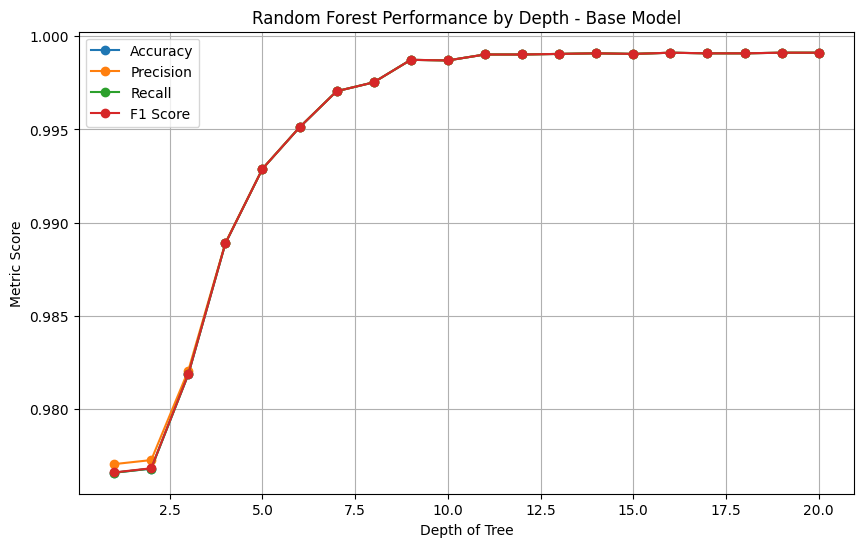

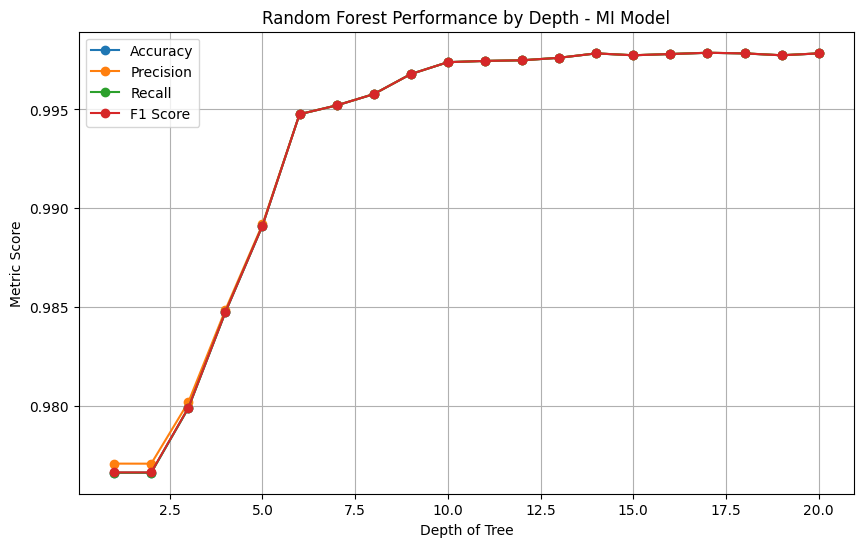

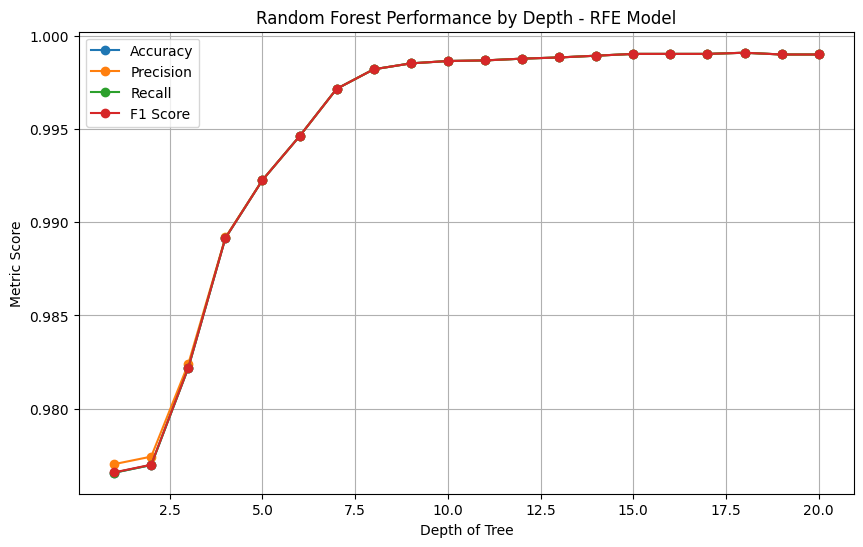

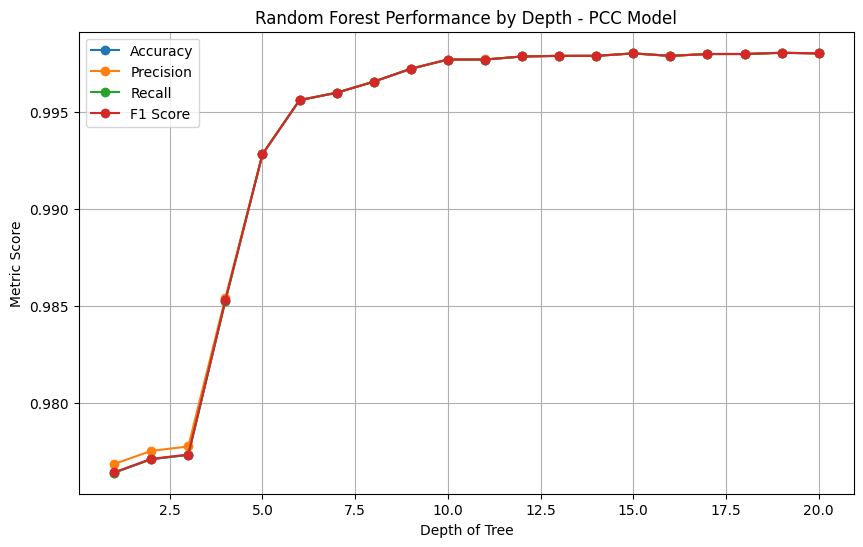

In [61]:
# Plotting the results for each subset separately
for subset_label, metrics in metrics_dicts.items():
    plt.figure(figsize=(10, 6))
    plt.plot(depth_range, metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(depth_range, metrics["precision"], label="Precision", marker='o')
    plt.plot(depth_range, metrics["recall"], label="Recall", marker='o')
    plt.plot(depth_range, metrics["f1"], label="F1 Score", marker='o')
    
    plt.title(f"Random Forest Performance by Depth - {subset_label} Model")
    plt.xlabel("Depth of Tree")
    plt.ylabel("Metric Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'Random Forest Performance by Depth - {subset_label} Model.png', bbox_inches='tight')
    plt.show()

# Train and test the final RF models

In [147]:
X = df.drop('Attack', axis=1)  # All columns except the target
y = df['Attack']               # The target column only

# Split into Train Validation and Test sets

# First split: 85% train+validation, 15% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

# Second split: 70% train, 15% validation from the train+validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, shuffle=True) # 0.1765 is approximately 15% of the 85% that was originally taken for train+validation 

### Multiple randomstates 

In [148]:
# Randomstates to use to make sure it is not a coincidence
RS_List = [123, 42, 21, 7, 11]

### Cross-validation

In [149]:
# Define number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Calculate complexity of a model

In [166]:
def calculate_model_complexity(rf_model, n_features):
    
    # Number of trees in the forest
    n_estimators = rf_model.n_estimators
    
    # Maximum depth of trees
    max_depth = rf_model.max_depth
    
    # Determine max_features for splits
    if rf_model.max_features == "sqrt":
        max_features = int(np.sqrt(n_features))
    elif rf_model.max_features == "log2":
        max_features = int(np.log2(n_features))
    elif rf_model.max_features is None:
        max_features = n_features  # Default is all features
    else:
        max_features = rf_model.max_features
    
    # Complexity per tree = max_depth * max_features
    comparisons_per_tree = max_depth * max_features
    
    # Total complexity = comparisons per tree * number of trees
    total_comparisons = comparisons_per_tree * n_estimators
    
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "max_features": max_features,
        "comparisons_per_tree": comparisons_per_tree,
        "total_comparisons_per_prediction": total_comparisons
    }


# Base RF model

In [168]:
# Initialize lists to store metrics for averaging
cv_means = []
cv_stds = []
val_accuracies = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
complexity_values = []  # Changed name to avoid confusion

for rs in RS_List:
    print(f"Random State: {rs}")
    # Initialize Random Forest with specified max depth and random state
    rf = RandomForestClassifier(max_depth=9, random_state=rs)
    
    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
    
    # Train the model on the entire training data
    rf.fit(X_train, y_train)
    
    # Evaluate on test data
    y_test_pred = rf.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Collect metrics
    cv_means.append(np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))
    val_accuracies.append(val_accuracy)
    confusion_matrices.append(confusion_matrix(y_test, y_test_pred))
    precision_scores.append(classification_rep['weighted avg']['precision'])
    recall_scores.append(classification_rep['weighted avg']['recall'])
    f1_scores.append(classification_rep['weighted avg']['f1-score'])
    
    # Calculate and collect complexity
    model_complexity = calculate_model_complexity(rf, X_train.shape[1])
    complexity_values.append(model_complexity['total_comparisons_per_prediction'])

# Calculate averages
avg_cv_mean = np.mean(cv_means)
avg_cv_std = np.mean(cv_stds)
avg_val_accuracy = np.mean(val_accuracies)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_complexity = np.mean(complexity_values)  # Use numerical values only

# Average the confusion matrix and round to integers
total_confusion_matrix = sum(confusion_matrices)
avg_confusion_matrix = np.round(total_confusion_matrix / len(RS_List)).astype(int)

# Display averaged results
print("\nAveraged Results Across Random States:")
print(f"Average CV Accuracy (Mean): {avg_cv_mean:.4f}")
print(f"Average CV Accuracy (Std Dev): {avg_cv_std:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f'Average Complexity of Model: {avg_complexity:.4f}')
print(f"Averaged Confusion Matrix (Rounded):\n{avg_confusion_matrix}")


Random State: 123
Random State: 42
Random State: 21
Random State: 7
Random State: 11

Averaged Results Across Random States:
Average CV Accuracy (Mean): 0.9983
Average CV Accuracy (Std Dev): 0.0004
Average Validation Accuracy: 0.9986
Average Precision: 0.9986
Average Recall: 0.9986
Average F1-Score: 0.9986
Average Complexity of Model: 6300.0000
Averaged Confusion Matrix (Rounded):
[[14773    21]
 [   23 16677]]


# PCC RF model

In [170]:
# Create Base tuple
PCC = (RF_X_train_pcc, RF_X_val_pcc, y_train, y_val, RF_X_test_pcc, y_test)

# Base dataset
RF_X_train_pcc, RF_X_val_pcc, y_train, y_val, RF_X_test_pcc, y_test = PCC

# Random states for robustness
RS_List = [123, 42, 21, 7, 11]

# Define number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for averaging
cv_means = []
cv_stds = []
val_accuracies = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
complexity_values = []

for rs in RS_List:
    print(f"Random State: {rs}")
    # Initialize Random Forest with specified max depth and random state
    rf = RandomForestClassifier(max_depth=10, random_state=rs)
    
    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(rf, RF_X_train_pcc, y_train, cv=kf, scoring='accuracy')
    
    # Train the model on the entire training data
    rf.fit(RF_X_train_pcc, y_train)
    
    # Evaluate on test data
    y_test_pred = rf.predict(RF_X_test_pcc)
    val_accuracy = accuracy_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Collect metrics
    cv_means.append(np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))
    val_accuracies.append(val_accuracy)
    confusion_matrices.append(confusion_matrix(y_test, y_test_pred))
    precision_scores.append(classification_rep['weighted avg']['precision'])
    recall_scores.append(classification_rep['weighted avg']['recall'])
    f1_scores.append(classification_rep['weighted avg']['f1-score'])
    
    # Calculate and collect complexity
    model_complexity = calculate_model_complexity(rf, RF_X_train_pcc.shape[1])
    complexity_values.append(model_complexity['total_comparisons_per_prediction'])

# Calculate averages
avg_cv_mean = np.mean(cv_means)
avg_cv_std = np.mean(cv_stds)
avg_val_accuracy = np.mean(val_accuracies)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_complexity = np.mean(complexity_values) 

# Average the confusion matrix and round to integers
total_confusion_matrix = sum(confusion_matrices)
avg_confusion_matrix = np.round(total_confusion_matrix / len(RS_List)).astype(int)

# Display averaged results
print("\nAveraged Results Across Random States:")
print(f"Average CV Accuracy (Mean): {avg_cv_mean:.4f}")
print(f"Average CV Accuracy (Std Dev): {avg_cv_std:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f'Average Complexity of Model: {avg_complexity:.4f}')
print(f"Averaged Confusion Matrix (Rounded):\n{avg_confusion_matrix}")



Random State: 123
Random State: 42
Random State: 21
Random State: 7
Random State: 11

Averaged Results Across Random States:
Average CV Accuracy (Mean): 0.9974
Average CV Accuracy (Std Dev): 0.0002
Average Validation Accuracy: 0.9976
Average Precision: 0.9976
Average Recall: 0.9976
Average F1-Score: 0.9976
Average Complexity of Model: 4000.0000
Averaged Confusion Matrix (Rounded):
[[14736    58]
 [   16 16684]]


# RFE RF

In [171]:
# Create Base tuple
PCC = (RF_X_train_RFE, RF_X_val_RFE, y_train, y_val, RF_X_test_RFE, y_test)

# Base dataset
RF_X_train_RFE, RF_X_val_RFE, y_train, y_val, RF_X_test_RFE, y_test = PCC

# Random states for robustness
RS_List = [123, 42, 21, 7, 11]

# Define number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for averaging
cv_means = []
cv_stds = []
val_accuracies = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
complexity_values = []

for rs in RS_List:
    print(f"Random State: {rs}")
    # Initialize Random Forest with specified max depth and random state
    rf = RandomForestClassifier(max_depth=8, random_state=rs)
    
    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(rf, RF_X_train_RFE, y_train, cv=kf, scoring='accuracy')
    
    # Train the model on the entire training data
    rf.fit(RF_X_train_RFE, y_train)
    
    # Evaluate on test data
    y_test_pred = rf.predict(RF_X_test_RFE)
    val_accuracy = accuracy_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Collect metrics
    cv_means.append(np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))
    val_accuracies.append(val_accuracy)
    confusion_matrices.append(confusion_matrix(y_test, y_test_pred))
    precision_scores.append(classification_rep['weighted avg']['precision'])
    recall_scores.append(classification_rep['weighted avg']['recall'])
    f1_scores.append(classification_rep['weighted avg']['f1-score'])
    
    # Calculate and collect complexity
    model_complexity = calculate_model_complexity(rf, RF_X_train_RFE.shape[1])
    complexity_values.append(model_complexity['total_comparisons_per_prediction'])

# Calculate averages
avg_cv_mean = np.mean(cv_means)
avg_cv_std = np.mean(cv_stds)
avg_val_accuracy = np.mean(val_accuracies)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_complexity = np.mean(complexity_values) 

# Average the confusion matrix and round to integers
total_confusion_matrix = sum(confusion_matrices)
avg_confusion_matrix = np.round(total_confusion_matrix / len(RS_List)).astype(int)

# Display averaged results
print("\nAveraged Results Across Random States:")
print(f"Average CV Accuracy (Mean): {avg_cv_mean:.4f}")
print(f"Average CV Accuracy (Std Dev): {avg_cv_std:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f'Average Complexity of Model: {avg_complexity:.4f}')
print(f"Averaged Confusion Matrix (Rounded):\n{avg_confusion_matrix}")



Random State: 123
Random State: 42
Random State: 21
Random State: 7
Random State: 11

Averaged Results Across Random States:
Average CV Accuracy (Mean): 0.9977
Average CV Accuracy (Std Dev): 0.0003
Average Validation Accuracy: 0.9981
Average Precision: 0.9981
Average Recall: 0.9981
Average F1-Score: 0.9981
Average Complexity of Model: 2400.0000
Averaged Confusion Matrix (Rounded):
[[14773    21]
 [   40 16660]]


# MI RF

In [172]:
# Create Base tuple
PCC = (RF_X_train_MI, RF_X_val_MI, y_train, y_val, RF_X_test_MI, y_test)

# Base dataset
RF_X_train_MI, RF_X_val_MI, y_train, y_val, RF_X_test_MI, y_test = PCC

# Random states for robustness
RS_List = [123, 42, 21, 7, 11]

# Define number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for averaging
cv_means = []
cv_stds = []
val_accuracies = []
confusion_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
complexity_values = []

for rs in RS_List:
    print(f"Random State: {rs}")
    # Initialize Random Forest with specified max depth and random state
    rf = RandomForestClassifier(max_depth=10, random_state=rs)
    
    # Perform K-Fold cross-validation
    cv_scores = cross_val_score(rf, RF_X_train_MI, y_train, cv=kf, scoring='accuracy')
    
    # Train the model on the entire training data
    rf.fit(RF_X_train_MI, y_train)
    
    # Evaluate on test data
    y_test_pred = rf.predict(RF_X_test_MI)
    val_accuracy = accuracy_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Collect metrics
    cv_means.append(np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))
    val_accuracies.append(val_accuracy)
    confusion_matrices.append(confusion_matrix(y_test, y_test_pred))
    precision_scores.append(classification_rep['weighted avg']['precision'])
    recall_scores.append(classification_rep['weighted avg']['recall'])
    f1_scores.append(classification_rep['weighted avg']['f1-score'])
    
    # Calculate and collect complexity
    model_complexity = calculate_model_complexity(rf, RF_X_train_MI.shape[1])
    complexity_values.append(model_complexity['total_comparisons_per_prediction'])

# Calculate averages
avg_cv_mean = np.mean(cv_means)
avg_cv_std = np.mean(cv_stds)
avg_val_accuracy = np.mean(val_accuracies)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_complexity = np.mean(complexity_values) 

# Average the confusion matrix and round to integers
total_confusion_matrix = sum(confusion_matrices)
avg_confusion_matrix = np.round(total_confusion_matrix / len(RS_List)).astype(int)

# Display averaged results
print("\nAveraged Results Across Random States:")
print(f"Average CV Accuracy (Mean): {avg_cv_mean:.4f}")
print(f"Average CV Accuracy (Std Dev): {avg_cv_std:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f'Average Complexity of Model: {avg_complexity:.4f}')
print(f"Averaged Confusion Matrix (Rounded):\n{avg_confusion_matrix}")



Random State: 123
Random State: 42
Random State: 21
Random State: 7
Random State: 11

Averaged Results Across Random States:
Average CV Accuracy (Mean): 0.9971
Average CV Accuracy (Std Dev): 0.0003
Average Validation Accuracy: 0.9973
Average Precision: 0.9973
Average Recall: 0.9973
Average F1-Score: 0.9973
Average Complexity of Model: 4000.0000
Averaged Confusion Matrix (Rounded):
[[14738    56]
 [   31 16669]]
